## Preprocessing et Modélisation des données avec des modèles de Machine Learning

In [92]:
# Importation de librairies
from IPython.display import display, HTML

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.feature_selection import (
    SelectKBest,
    f_classif, mutual_info_classif, f_regression, mutual_info_regression)

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold, GridSearchCV,
    cross_validate, cross_val_score, cross_val_predict)
from sklearn.metrics import make_scorer

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from scipy.sparse import csr_matrix, hstack

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier, RUSBoostClassifier
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier,
    VotingClassifier, StackingClassifier,
    AdaBoostClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier

from imblearn.metrics import (
    classification_report_imbalanced)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score)

from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.tree import plot_tree

from sklearn.feature_selection import SelectFromModel

import mlflow
import joblib, pickle
import tempfile, os, time

import shap, lime

In [45]:
# Importation des données traitées (multiclass) dans un DataFrame
df = pd.read_parquet('../data/processed/processed_reviews_multiclass.parquet')

In [46]:
# Réglage de l'affichage des DataFrames
pd.set_option('display.max_colwidth', None)
#pd.reset_option('display.max_colwidth', 'display.width')

# Affichage des 5 premières lignes
df.head()

pseudo          publication_date  rating  \
0  GERARD CATALA 2025-03-07 14:48:17+01:00       5   
1            JFD 2025-03-07 14:45:35+01:00       5   
2    Catherine B 2025-03-07 14:35:24+01:00       5   
3         Amir B 2025-03-07 14:20:03+01:00       4   
4  Fontaine Joël 2025-03-07 13:28:32+01:00       4   

                                 title  \
0                     Banque pas chère   
1                Modif plafond retrait   
2                             Facilité   
3             Trop d'étape de sécurité   
4  Je recommande cette carte pour les…   

                                                                                                                                                                                                                             review  \
0                                                                                                                                                                                                                  Banque pas chère   
1                                                                                                                                                                        Gestion aisée de mon compte. Pas de frais, aucun problème.   
2                                                                                                                                                                              Rajouter un bénéficiaire et tout s'est bien déroulé.   
3  J'ai mis 4 étoiles parce que je trouve qu'il a beaucoup etapes de sécurité C'est compréhensif mais ça mis trop de temps et trop d'étape pour faire un truc simple C'était juste mes débuts peut-être après je changerai d'avis 😉   
4                                                                                                                                                   Je recommande cette carte pour les voyageurs et pour les commandes sur internet   

  experience_date  total_reviews        bank  year  month  ... weekday  hour  \
0      2025-03-07             13  boursobank  2025      3  ...       4    14   
1      2025-03-07              2  boursobank  2025      3  ...       4    14   
2      2025-03-07              1  boursobank  2025      3  ...       4    14   
3      2025-03-01              1  boursobank  2025      3  ...       4    14   
4      2025-03-06              6  boursobank  2025      3  ...       4    13   

           cleaned_title  \
0                  chère   
1  modif plafond retrait   
2               facilité   
3    trop étape sécurité   
4      recommander carte   

                                                                                                             cleaned_review  \
0                                                                                                                     chère   
1                                                                                  gestion aisé compte frais aucun problème   
2                                                                                       rajouter bénéficiaire bien dérouler   
3  mis étoiler trouver beaucoup etapes sécurité compréhensif mis trop temps trop étape faire truc simple début changer avis   
4                                                                              recommander carte voyageur commande internet   

  exclamation_marks_count  question_marks_count  ellipsis_count  \
0                       0                     0               0   
1                       0                     0               0   
2                       0                     0               0   
3                       0                     0               0   
4                       0                     0               0   

   characters_count  polarity  subjectivity  
0                16     0.105          0.40  
1                58     0.300          0.20  
2                52     0.110          0.15  
3               224    -0.016          0.36  

In [47]:
# Nbre de lignes et de colonnes
print(f'Le DataFrame comporte {df.shape[0]} lignes et {df.shape[1]} colonnes. \n')

# Infos sur le DataFrame
df.info()

Le DataFrame comporte 48385 lignes et 21 colonnes. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48385 entries, 0 to 48384
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype                       
---  ------                   --------------  -----                       
 0   pseudo                   48385 non-null  object                      
 1   publication_date         48385 non-null  datetime64[ns, Europe/Paris]
 2   rating                   48385 non-null  int64                       
 3   title                    48385 non-null  object                      
 4   review                   48385 non-null  object                      
 5   experience_date          48385 non-null  datetime64[ns]              
 6   total_reviews            48385 non-null  int64                       
 7   bank                     48385 non-null  object                      
 8   year                     48385 non-null  int32                       
 9   month   

### Nettoyage des doublons et des valeurs manquantes

In [48]:
# Nbre de lignes en doublon
print(f'Il y a {df.duplicated().sum()} ligne(s) en doublon dans le DataFrame.')

# Lignes en doublon
df[df.duplicated(keep=False)].sort_values(by='pseudo')

Il y a 0 ligne(s) en doublon dans le DataFrame.


Empty DataFrame
Columns: [pseudo, publication_date, rating, title, review, experience_date, total_reviews, bank, year, month, year_month, weekday, hour, cleaned_title, cleaned_review, exclamation_marks_count, question_marks_count, ellipsis_count, characters_count, polarity, subjectivity]
Index: []

[0 rows x 21 columns]

In [49]:
# Nbre de valeurs manquantes
print(f'Il y a {df.isna().sum().sum()} valeur(s) manquante(s) dans le DataFrame.')

# Nbre de valeurs manquantes par colonne
df.isna().sum()

Il y a 1082 valeur(s) manquante(s) dans le DataFrame.


pseudo                        0
publication_date              0
rating                        0
title                         0
review                        0
experience_date               0
total_reviews                 0
bank                          0
year                          0
month                         0
year_month                    0
weekday                       0
hour                          0
cleaned_title              1014
cleaned_review               68
exclamation_marks_count       0
question_marks_count          0
ellipsis_count                0
characters_count              0
polarity                      0
subjectivity                  0
dtype: int64

In [50]:
# Suppression des lignes ne comportant aucune valeur dans "cleaned_review" et Réinitialisation de l'index
df.dropna(subset='cleaned_review', inplace=True)
df.reset_index(drop=True, inplace=True)

# Nbre de valeurs manquantes par colonne
df.isna().sum()

pseudo                       0
publication_date             0
rating                       0
title                        0
review                       0
experience_date              0
total_reviews                0
bank                         0
year                         0
month                        0
year_month                   0
weekday                      0
hour                         0
cleaned_title              977
cleaned_review               0
exclamation_marks_count      0
question_marks_count         0
ellipsis_count               0
characters_count             0
polarity                     0
subjectivity                 0
dtype: int64

In [51]:
# Infos sur le DataFrame
df.info()

# Affichage de la 1re ligne
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48317 entries, 0 to 48316
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype                       
---  ------                   --------------  -----                       
 0   pseudo                   48317 non-null  object                      
 1   publication_date         48317 non-null  datetime64[ns, Europe/Paris]
 2   rating                   48317 non-null  int64                       
 3   title                    48317 non-null  object                      
 4   review                   48317 non-null  object                      
 5   experience_date          48317 non-null  datetime64[ns]              
 6   total_reviews            48317 non-null  int64                       
 7   bank                     48317 non-null  object                      
 8   year                     48317 non-null  int32                       
 9   month                    48317 non-null  int32               

pseudo          publication_date  rating             title  \
0  GERARD CATALA 2025-03-07 14:48:17+01:00       5  Banque pas chère   

             review experience_date  total_reviews        bank  year  month  \
0  Banque pas chère      2025-03-07             13  boursobank  2025      3   

   ... weekday  hour  cleaned_title cleaned_review exclamation_marks_count  \
0  ...       4    14          chère          chère                       0   

   question_marks_count  ellipsis_count  characters_count  polarity  \
0                     0               0                16     0.105   

   subjectivity  
0           0.4  

[1 rows x 21 columns]

### Preprocessing

#### Sélection de variables

In [52]:
# Séparation des variables explicatives de la variable cible
X = df.iloc[:, 15:]
y = df['rating']

# Séparation des observations en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,      # Mélange les données avant de faire la séparation train / test (valeur par défaut)
                                                    stratify=y,        # Permet une répartition similaire des classes dans les 2 ensembles
                                                    random_state=42)

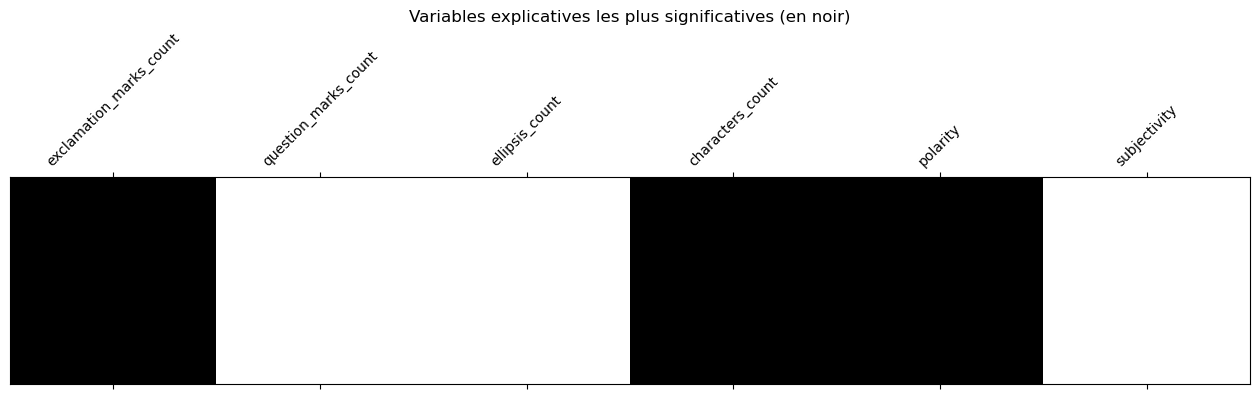

In [53]:
# Sélection des 3 variables explicatives les plus significatives selon une fonction de score
select_kbest = SelectKBest(score_func=f_classif, k=3)   # OU mutual_info_classif, f_regression, mutual_info_regression
select_kbest.fit(X=X_train, y=y_train)
mask = select_kbest.get_support()

# Affichage des résultats
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

plt.xticks(ticks=range(X_train.shape[1]), labels=X_train.columns, rotation=45)
plt.yticks([])
plt.title('Variables explicatives les plus significatives (en noir)');

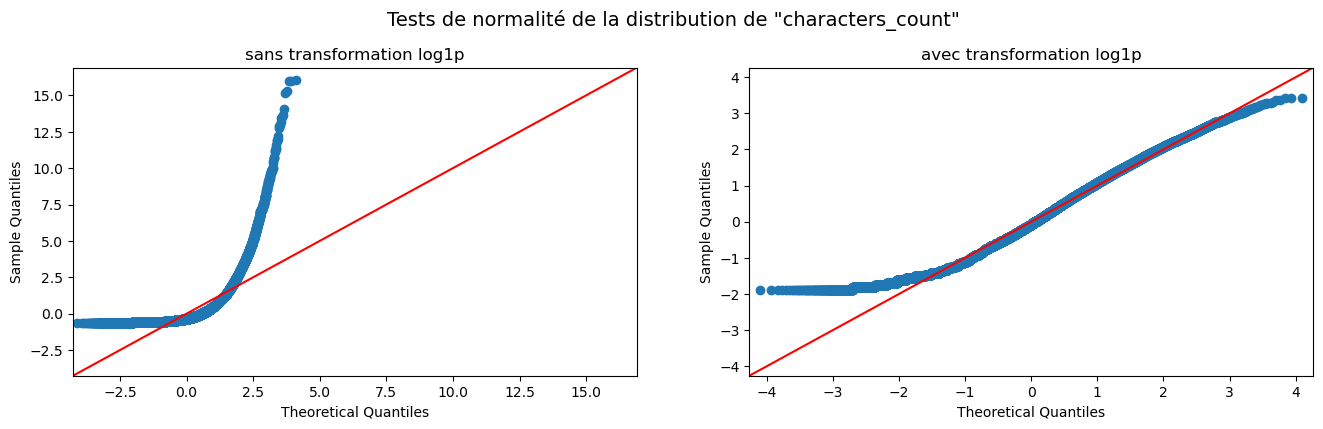

In [54]:
# Tests de normalité de la distribution de "characters_count"
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Sans transformation log1p
sm.qqplot(df['characters_count'], fit=True, line='45', ax=axes[0])
#axes[0].set_xlabel('')
#axes[0].set_ylabel('')
axes[0].set_title('sans transformation log1p')

# Avec transformation log1p
sm.qqplot(np.log1p(df['characters_count']), fit=True, line='45', ax=axes[1])
#axes[1].set_xlabel('')
#axes[1].set_ylabel('')
axes[1].set_title('avec transformation log1p')

fig.suptitle('Tests de normalité de la distribution de "characters_count"', fontsize=14, y=1.025)

plt.show()

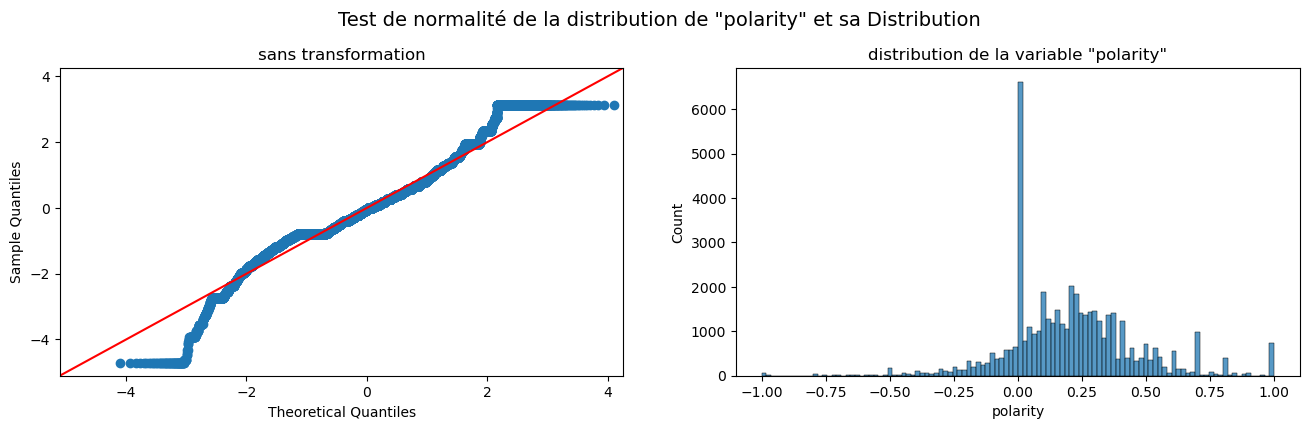

In [55]:
# Test de normalité de la distribution de "polarity" et sa Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Sans transformation
sm.qqplot(df['polarity'], fit=True, line='45', ax=axes[0])
#axes[0].set_xlabel('')
#axes[0].set_ylabel('')
axes[0].set_title('sans transformation')

# Distribution de la variable "polarity"
sns.histplot(df['polarity'], ax=axes[1])
#axes[1].set_xlabel('')
#axes[1].set_ylabel('')
axes[1].set_title('distribution de la variable "polarity"')

fig.suptitle('Test de normalité de la distribution de "polarity" et sa Distribution', fontsize=14, y=1.025)

plt.show()

In [56]:
'''
Transformations possibles :
- Pour la variable "characters_count" : Utilisation d'un log1p ; Discrétisation ; Retrait de valeurs extrêmes
- Pour la variable "polarity" : Traitement du pic à 0.00 ; Discrétisation ; Retrait de valeurs extrêmes
'''

'\nTransformations possibles :\n- Pour la variable "characters_count" : Utilisation d\'un log1p ; Discrétisation ; Retrait de valeurs extrêmes\n- Pour la variable "polarity" : Traitement du pic à 0.00 ; Discrétisation ; Retrait de valeurs extrêmes\n'

#### Gestion du déséquilibre des classes

In [57]:
# Proportions des classes initiales
df['rating'].value_counts(normalize=True).sort_index() * 100

rating
1    18.159240
2     3.404599
3     3.530848
4     9.216218
5    65.689095
Name: proportion, dtype: float64

In [58]:
# Regroupement des classes 1 et 2 dans une nouvelle classe 0, et des classes 3, 4 et 5 dans une nouvelle classe 1
df['binary_rating'] = df['rating'].replace({1: 0, 2: 0,
                                            3: 1, 4: 1, 5: 1})

# Proportions des classes après regroupement
df['binary_rating'].value_counts(normalize=True).sort_index() * 100

binary_rating
0    21.563839
1    78.436161
Name: proportion, dtype: float64

In [59]:
# Sauvegarde du DataFrame traité dans un fichier Parquet

# >>> ATTENTION ! <<< un fichier Parquet existe déjà dans "data/processed/"
#df.to_parquet('../data/processed/processed_reviews.parquet', index=False)

#### Sélection / Séparations des variables (X, y) et des observations (train, test)

In [60]:
# Sélection / Séparation des variables explicatives de la variable cible
X = df[['characters_count', 'polarity', 'cleaned_review']]
y = df['binary_rating']

# Séparation des observations en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,      # Mélange les données avant de faire la séparation train / test (valeur par défaut)
                                                    stratify=y,        # Permet une répartition similaire des classes dans les 2 ensembles
                                                    random_state=42)

# Vérification que les proportions des classes après séparation sont préservées
y_train.value_counts(normalize=True).sort_index() * 100

binary_rating
0    21.563656
1    78.436344
Name: proportion, dtype: float64

### Fonctions de preprocessing, modélisation, évaluation et tracking

In [18]:
# 9 FONCTIONS :

# Fonction pour créer un pipeline dans une GridSearchCV
def create_pipeline_grid(model_function, param_grid, y_train, over_ratio=1.5, under_ratio=1.5):

    """
    Definition :
    -

    Parameters :
    -

    Returns :
    -
    """

    # Nombre d'échantillons par classe à atteindre après rééchantillonnage
    over_sample = {0: int(y_train.value_counts()[0] * over_ratio)}
    under_sample = {1: int(y_train.value_counts()[1] // under_ratio)}

    # Création du pipeline
    pipeline = ImbPipeline([
        ('preprocessing', ColumnTransformer(transformers=[
            ('vectorizer', CountVectorizer(), 'cleaned_review'),
            ('scaler', StandardScaler(), ['characters_count', 'polarity'])
        ])),
        ('oversampler', RandomOverSampler(sampling_strategy=over_sample, random_state=42)),
        ('undersampler', RandomUnderSampler(sampling_strategy=under_sample, random_state=42)),
        ('model', model_function)
    ])

    # Création des plis stratifiés
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Création du scorer
    f1_score_class_0 = make_scorer(score_func=f1_score, pos_label=0)

    # puis Création de la GridSearchCV avec le pipeline, etc...
    return GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=stratified_kfold, scoring=f1_score_class_0, n_jobs=-1, verbose=10)


# Fonction pour entraîner une GridSearchCV et afficher les résultats
def fit_grid_display_results(model_name, grid, param_grid, X_train, y_train, common_cols_cv_results):

    """
    Definition :
    -

    Parameters :
    -

    Returns :
    -
    """

    # Entraînement de la GridSearchCV sur l'ensemble d'entraînement
    trained_grid = grid.fit(X_train, y_train)

    # Résultats de la GridSearchCV
    display('----------------------------------------------------------------------------------------------------')
    print(f'\033[1;4m{model_name}\033[0m', end='\n\n')
    print('\033[1mRésultats de la GridSearchCV sur l\'ensemble d\'entraînement :\033[0m', end='\n')

    # Pour réordonner les colonnes
    specific_cols_cv_results = [f'param_{key}' for key in param_grid.keys()]
    cols_cv_results = specific_cols_cv_results + common_cols_cv_results

    # Pour renommer les colonnes
    renamed_cols = {f'param_{key}': key.split('__')[-1] for key in param_grid.keys()}

    cv_results = pd.DataFrame(trained_grid.cv_results_)[cols_cv_results].rename(columns=renamed_cols).round(decimals=4).sort_values(by='rank_test_score')
    html_cv_results = cv_results.to_html()
    display(HTML(f"<div style='height: 400px; overflow: auto;'>{html_cv_results}</div>"))

    # Meilleurs hyperparamètres de la GridSearchCV et Meilleur F1-score pour la classe 0
    print('\033[1mMeilleurs hyperparamètres de la GridSearchCV sur l\'ensemble d\'entraînement :\033[0m', end='\n')
    print(trained_grid.best_params_, end='\n\n')
    print(f"\033[1mMeilleur F1-score pour la classe 0 :\033[0m {np.round(cv_results.iloc[0]['mean_test_score'], decimals=4)}\
            \033[1mavec un écart-type de :\033[0m {np.round(cv_results.iloc[0]['std_test_score'], decimals=4)}", end='\n\n')

    return trained_grid, cv_results


# Fonction pour prédire avec une GridSearchCV entraînée (par défaut : sur le Meilleure modèle) et afficher les résultats
def predict_grid_display_results(trained_grid, X_test, y_test):

    """
    Definition :
    -

    Parameters :
    -

    Returns :
    -
    """

    # Prédiction avec le Meilleur modèle sur l'ensemble de test
    y_pred = trained_grid.predict(X_test)

    # Rapport de classification du Meilleur modèle
    print('\033[1mRapport de classification du Meilleur modèle sur l\'ensemble de test :\033[0m')
    print(classification_report_imbalanced(y_test, y_pred))

    # Matrice de confusion du Meilleur modèle
    print('\033[1mMatrice de confusion du Meilleur modèle sur l\'ensemble de test :\033[0m')
    display(pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites']))

    return y_pred


# Fonction pour logger un fichier temporaire (CSV ou PNG) en tant qu'artefact dans MLflow
def log_artifact(content, filename, filetype, artifact_path, run_id=None):
    
    """
    Definition :
    - Log a temporary file (CSV or PNG) as an artifact in MLflow.

    Parameters :
    - content (Pandas DataFrame or Matplotlib Figure) : A content to log as an artifact.
    - filename (str) : The filename of the artifact (without extension).
    - filetype (str) : The type of the file ("csv" or "png").
    - artifact_path (str): The subdirectory in the artifact repository.
    - run_id (str) : The ID of the MLflow run. Default is None.

    Returns :
    - None.
    """

    if filetype not in ['csv', 'png']:
        raise ValueError('Type de fichier non supporté. Utiliser "csv" ou "png".')

    def _save_temp_file_and_log():

        with tempfile.TemporaryDirectory() as temp_dir:

            temp_file_path = os.path.join(temp_dir, f'{filename}.{filetype}')

            try:
                if filetype == 'csv':
                    if isinstance(content, pd.DataFrame):
                        content.to_csv(temp_file_path, index=False)
                    else:
                        raise ValueError('Pour le type de fichier "csv", le contenu doit être un DataFrame Pandas.')
                    
                elif filetype == 'png':
                    if isinstance(content, plt.Figure):
                        content.savefig(temp_file_path, bbox_inches='tight')
                    else:
                        raise ValueError('Pour le type de fichier "png", le contenu doit être un graphique Matplotlib.')
                    
            except Exception as e:
                raise ValueError(f'Erreur lors de la sauvegarde du fichier {filetype}: {e}')
            
            mlflow.log_artifact(local_path=temp_file_path, artifact_path=artifact_path)

    if run_id:
        with mlflow.start_run(run_id=run_id):
            _save_temp_file_and_log()
            
            return run_id
    else:
        _save_temp_file_and_log()


# Fonction pour logger les résultats / les runs dans MLflow
def mlflow_log(run_name, trained_grid, cv_results, y_test, y_pred):

    """
    Definition :
    -

    Parameters :
    -

    Returns :
    -
    """

    # Création d'un DataFrame du Rapport de classification du Meilleur modèle
    df_temp_1 = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, output_dict=True)).T.iloc[:2]
    df_temp_2 = pd.DataFrame(classification_report_imbalanced(y_test, y_pred, output_dict=True)).iloc[0, 2:].to_frame().T
        
    df_temp_2.columns = df_temp_1.columns
    df_temp_2.index = ['weighted avg / total']

    report_imbalanced = pd.concat([df_temp_1, df_temp_2]).round(decimals=2).reset_index(names='Classes')


    # Logging avec MLflow
    mlflow.set_tracking_uri(uri='file:../mlflow/mlruns/')   # Après l'exécution de la cellule de code,
                                                            # dans un Terminal, lancer depuis la racine du projet : "mlflow ui --backend-store-uri file:./mlflow/mlruns/ --port 5000"
                                                            # puis dans un Navigateur web, se rendre sur : "http://127.0.0.1:5000/"
    mlflow.set_experiment(experiment_name='classification_bank_customer_review')

    with mlflow.start_run(run_name=f'{run_name}') as run:
        run_id = run.info.run_id

        # Log des Meilleurs hyperparamètres et des Meilleurs scores pour la classe 0
        renamed_params = {key.split('__')[-1]: value for key, value in trained_grid.best_params_.items()}
        mlflow.log_params(renamed_params)

        mlflow.log_metric(key='best_f1-score_class_0', value=np.round(cv_results.iloc[0]['mean_test_score'], decimals=4))
        mlflow.log_metric(key='std_test_score', value=np.round(cv_results.iloc[0]['std_test_score'], decimals=4))
        mlflow.log_metric(key='mean_score_time', value=np.round(cv_results.iloc[0]['mean_score_time'], decimals=4))
        mlflow.log_metric(key='std_score_time', value=np.round(cv_results.iloc[0]['std_score_time'], decimals=4))
        mlflow.log_metric(key='mean_fit_time', value=np.round(cv_results.iloc[0]['mean_fit_time'], decimals=4))
        # Ajouter 'std_fit_time'

        mlflow.log_metric(key='best_precision_class_0', value=df_temp_1.loc['0']['pre'].round(decimals=4))
        mlflow.log_metric(key='best_recall_class_0', value=df_temp_1.loc['0']['rec'].round(decimals=4))
        mlflow.log_metric(key='best_specificity_class_0', value=df_temp_1.loc['0']['spe'].round(decimals=4))
        mlflow.log_metric(key='best_geo_class_0', value=df_temp_1.loc['0']['geo'].round(decimals=4))
        mlflow.log_metric(key='best_iba_class_0', value=df_temp_1.loc['0']['iba'].round(decimals=4))

        # Log des Résultats de la GridSearchCV
        log_artifact(content=cv_results, filename=f'cv_results_{run_name}',
                     filetype='csv', artifact_path='model_outputs')

        # Log du Rapport de classification du Meilleur modèle
        log_artifact(content=report_imbalanced, filename=f'classification_report_{run_name}',
                     filetype='csv', artifact_path='model_outputs')

        # Log de la Matrice de confusion du Meilleur modèle
        log_artifact(content=pd.crosstab(y_test, y_pred).reset_index(names='Classes réelles \ Classes prédites'), filename=f'confusion_matrix_{run_name}',
                     filetype='csv', artifact_path='model_outputs')

        # Log du Meilleur modèle au format "Pickle" (par défaut : avec MLflow) et Enregistrement du Meilleur modèle au format "Joblib"
        mlflow.sklearn.log_model(sk_model=trained_grid.best_estimator_, artifact_path='model', registered_model_name=f'{run_name}_best_model')   # input_example
        joblib.dump(value=trained_grid.best_estimator_, filename=f'../models/{run_name}_best_model.joblib')

        # Calcul de la durée approximative de l'entraînement et de la prédiction
        formatted_duration, duration = compute_duration(start_time, end_time)

        # Log de la durée approximative de l'entraînement et de la prédiction
        mlflow.log_param(key='duration_str_fit_predict', value=formatted_duration)
        mlflow.log_metric(key='duration_seconds_fit_predict', value=duration)
        mlflow.set_tag(key='duration_str_fit_predict', value=formatted_duration)

        return run_id


# Fonction pour calculer la durée approximative de l'entraînement et de la prédiction
def compute_duration(start_time, end_time):

    """
    Definition :
    -

    Parameters :
    -

    Returns :
    -
    """

    # Calcul de la durée approximative de l'entraînement et de la prédiction
    duration = int(end_time - start_time)
    hours, remainder = divmod(duration, 3600)
    minutes, seconds = divmod(remainder, 60)
    formatted_duration = f'{hours} h {minutes} min {seconds} s' if hours else f'{minutes} min {seconds} s'

    return formatted_duration, duration


# Fonction pour afficher des courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée
def plot_learning_curves(model_name, pipeline_without_sampling, X_train, y_train, stratified_kfold, f1_score_class_0):

    """
    Definition :
    -

    Parameters :
    -

    Returns :
    -
    """
    
    # Calcul des courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée
    train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline_without_sampling, X=X_train, y=y_train,
                                                            train_sizes=np.linspace(0.1, 1, 5), cv=stratified_kfold, scoring=f1_score_class_0,
                                                            n_jobs=-1, shuffle=True, random_state=42)

    # Calcul des moyennes et des écart-types des scores sur les sous-ensembles d'entraînement et de test (validation croisée)
    mean_train_score = train_scores.mean(axis=1)
    std_train_score = train_scores.std(axis=1)
    mean_test_score = test_scores.mean(axis=1)
    std_test_score = test_scores.std(axis=1)

    # Affichage des courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(train_sizes, mean_train_score, 'o-', color='blue', label='Moyenne des scores d\'entraînement')
    ax.fill_between(train_sizes, mean_train_score - std_train_score, mean_train_score + std_train_score, color='blue', alpha=0.2)
    ax.plot(train_sizes, mean_test_score, 'o-', color='red', label='Moyenne des scores de test (validation croisée)')
    ax.fill_between(train_sizes, mean_test_score - std_test_score, mean_test_score + std_test_score, color='red', alpha=0.2)

    ax.set_xlabel('Taille de l\'ensemble d\'entraînement')
    ax.set_ylabel('F1-score de la classe 0')
    ax.set_title(f'Courbes d\'apprentissage\n\
    pour le {model_name} sur l\'ensemble d\'entraînement avec validation croisée')

    ax.legend(loc='best')
    ax.grid()
    plt.show()

    return fig


# Fonction pour afficher une courbe Précision - Rappel sur l'ensemble de test
def plot_precision_recall_curve(model_name, trained_grid, X_test, y_test):

    """
    Definition :
    -

    Parameters :
    -

    Returns :
    -
    """

    # Calcul de la courbe Précision - Rappel sur l'ensemble de test
    precision, recall, thresholds = precision_recall_curve(y_test, trained_grid.predict_proba(X_test)[:, 0], pos_label=0)

    # Seuil qui maximise la Précision et le Rappel (basé sur le F1-score)
    f1_scores_class_0 = (2 * precision * recall) / (precision + recall)
    precision_best_threshold = precision[np.argmax(f1_scores_class_0)]
    recall_best_threshold = recall[np.argmax(f1_scores_class_0)]
    best_threshold = thresholds[np.argmax(f1_scores_class_0)]

    # Affichage de la courbe Précision - Rappel sur l'ensemble de test
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(recall, precision, color='blue', lw=2, zorder=2, label='Seuils de 1 à 0')
    ax.scatter(recall_best_threshold, precision_best_threshold, color='red', zorder=3, label=f'Meilleur seuil maximisant la Précision et le Rappel \n\
    (basé sur le F1-score) : {best_threshold:.4f}')

    ax.set_xlabel('Rappel')
    ax.set_ylabel('Précision')
    ax.set_title(f'Courbe Précision - Rappel\n\
    pour le {model_name} sur l\'ensemble de test')

    ax.legend(loc='best')
    ax.grid()
    plt.show()

    return fig


# Fonction pour afficher une courbe ROC sur l'ensemble de test et l'aire sous la courbe (AUC)
def plot_roc_curve(model_name, trained_grid, X_test, y_test):

    """
    Definition :
    -

    Parameters :
    -

    Returns :
    -
    """

    # Calcul de la courbe ROC (Rappel - Taux de Faux Positifs) sur l'ensemble de test et de l'aire sous la courbe (AUC)
    fpr, tpr, thresholds = roc_curve(y_test, trained_grid.predict_proba(X_test)[:, 0], pos_label=0)
    roc_auc = auc(fpr, tpr)

    # Affichage de la courbe ROC sur l'ensemble de test et de l'aire sous la courbe (AUC)
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(fpr, tpr, color='orange', lw=2, label=f'Seuils de 1 à 0 (auc = {roc_auc:.2f})')

    ax.set_xlabel('Taux de Faux Positifs')
    ax.set_ylabel('Rappel')
    ax.set_title(f'Courbe ROC\n\
    pour le {model_name} sur l\'ensemble de test')

    ax.legend(loc='best')
    ax.grid()
    plt.show()

    return fig

### Modélisation

In [19]:
# Réordonnancement des colonnes communes des Résultats de la GridSearchCV
common_cols_cv_results = ['mean_score_time', 'std_score_time',
                          'rank_test_score',
                          'mean_test_score', 'std_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score',
                          'mean_fit_time', 'std_fit_time',
                          'params']

In [20]:
# Exemple d'entrée pour MLflow
#input_example = {
#    'characters_count': X_train.iloc[0]['characters_count'],
#    'polarity': X_train.iloc[0]['polarity'],
#    'cleaned_review': X_train.iloc[0]['cleaned_review']
#    }

#### LOGISTIC REGRESSION

In [127]:
# Création d'une grille de recherche
param_grid = {
    'preprocessing__vectorizer': [CountVectorizer(min_df=7), TfidfVectorizer(min_df=7)],
    'preprocessing__scaler': [StandardScaler(), RobustScaler()],
    'model__penalty': ['l2'],
    'model__C': [0.1, 1.0, 10],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [3000],
    'model__class_weight': [None, 'balanced']
    }

In [ ]:
%%time
start_time = time.perf_counter()

model_name = 'Logistic Regression'
run_name = 'logistic_regression'

# Création d'un pipeline dans une GridSearchCV
grid = create_pipeline_grid(
    LogisticRegression(random_state=42),
    param_grid,
    y_train
    )
    
# Entraînement de la GridSearchCV et Affichage des résultats
trained_grid, cv_results = fit_grid_display_results(
    model_name.upper(),
    grid,
    param_grid,
    X_train,
    y_train,
    common_cols_cv_results
    )

# Prédiction avec la GridSearchCV entraînée et Affichage des résultats
y_pred = predict_grid_display_results(
    trained_grid,
    X_test,
    y_test
    )

end_time = time.perf_counter()

# Log des résultats dans MLflow
run_id = mlflow_log(
    run_name,
    trained_grid,
    cv_results,
    y_test,
    y_pred
    )

# Calcul et Affichage de la durée approximative de l'entraînement et de la prédiction
print()
print(f'\033[1mDurée approximative de l\'entraînement et de la prédiction :\033[0m {compute_duration(start_time, end_time)[0]}', end='\n\n')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 2/48] START model__C=0.1, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)
[CV 3/5; 2/48] START model__C=0.1, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)
[CV 4/5; 1/48] START model__C=0.1, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 5/5; 2/48] START model__C=0.1, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)
[CV 2/5; 1/48] START model__C=0.1, model__class_weight=None, m

/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 37/48] END model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.828 total time= 2.1min
[CV 3/5; 37/48] END model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.838 total time= 2.1min
[CV 4/5; 40/48] START model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)
[CV 5/5; 40/48] START model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)
[CV 2/5; 37/48] END model__C=10, model__class_weight=None, model__max_iter=3000, model

/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 37/48] END model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.831 total time= 2.1min
[CV 2/5; 41/48] START model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)


/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 37/48] END model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.829 total time= 2.1min
[CV 3/5; 41/48] START model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 2/5; 40/48] END model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7);, score=0.844 total time= 1.2min
[CV 4/5; 41/48] START model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)


/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 41/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.819 total time=   4.4s
[CV 1/5; 39/48] END model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.831 total time= 2.1min
[CV 1/5; 41/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.822 total time=   5.1s
[CV 5/5; 41/48] START model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 1/5; 42/48] START mode

/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 42/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7);, score=0.833 total time=   2.0s
[CV 5/5; 42/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7);, score=0.834 total time=   1.8s
[CV 4/5; 43/48] START model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=liblinear, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 2/5; 39/48] END model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.832 total time= 2.1min
[CV 5/5; 43/48] START model_

/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 39/48] END model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.840 total time= 2.0min
[CV 2/5; 46/48] START model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)


/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 39/48] END model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.833 total time= 2.0min
[CV 3/5; 46/48] START model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)
[CV 4/5; 39/48] END model__C=10, model__class_weight=None, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.830 total time= 2.0min
[CV 4/5; 46/48] START model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)
[CV 3/5; 40/48] END model__C=10, model__class_weight=None, model__max_iter=300

/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 45/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.828 total time= 1.9min
[CV 3/5; 48/48] START model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)


/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 45/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.836 total time= 1.9min
[CV 4/5; 48/48] START model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)


/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5; 45/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.823 total time= 1.9min
[CV 5/5; 45/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.827 total time= 1.9min
[CV 5/5; 48/48] START model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)


/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 45/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.826 total time= 1.9min
[CV 1/5; 48/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7);, score=0.835 total time=  54.1s
[CV 2/5; 48/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7);, score=0.838 total time=  57.4s


/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5; 47/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.830 total time= 1.7min


/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5; 47/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.839 total time= 1.6min
[CV 2/5; 47/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.823 total time= 1.6min
[CV 3/5; 48/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7);, score=0.854 total time=  44.3s
[CV 5/5; 48/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7);, score=0.836 total time=  44.5s
[CV 4/5; 48/

/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5; 47/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.829 total time= 1.4min


/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5; 47/48] END model__C=10, model__class_weight=balanced, model__max_iter=3000, model__penalty=l2, model__solver=saga, preprocessing__scaler=RobustScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7);, score=0.830 total time= 1.4min


'----------------------------------------------------------------------------------------------------'

LOGISTIC REGRESSION

Résultats de la GridSearchCV sur l'ensemble d'entraînement :


Meilleurs hyperparamètres de la GridSearchCV sur l'ensemble d'entraînement :
{'model__C': 1.0, 'model__class_weight': None, 'model__max_iter': 3000, 'model__penalty': 'l2', 'model__solver': 'saga', 'preprocessing__scaler': StandardScaler(), 'preprocessing__vectorizer': TfidfVectorizer(min_df=7)}

Meilleur F1-score pour la classe 0 : 0.8459            avec un écart-type de : 0.0069

Rapport de classification du Meilleur modèle sur l'ensemble de test :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.90      0.94      0.85      0.92      0.84      2084
          1       0.97      0.94      0.90      0.96      0.92      0.85      7580

avg / total       0.94      0.93      0.91      0.93      0.92      0.85      9664

Matrice de confusion du Meilleur modèle sur l'ensemble de test :


Classes prédites     0     1
Classes réelles             
0                 1869   215
1                  435  7145

2025/05/19 10:13:06 INFO mlflow.tracking.fluent: Experiment with name 'classification_bank_customer_review' does not exist. Creating a new experiment.
2025/05/19 10:13:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Durée approximative de l'entraînement et de la prédiction : 8 min 50 s

CPU times: user 12.6 s, sys: 3.76 s, total: 16.3 s
Wall time: 8min 59s


Successfully registered model 'logistic_regression_best_model'.
Created version '1' of model 'logistic_regression_best_model'.


In [83]:
# Création d'un pipeline sans rééchantillonnage et avec les Meilleurs hyperparamètres (avec rééchantillonnage, cela pose un pb sur les petits sous-ensembles car le taux de rééchantillonnage est fixe (à 1.5))
pipeline_without_sampling = ImbPipeline([
    ('preprocessing', ColumnTransformer(transformers=[
        ('vectorizer', TfidfVectorizer(min_df=7), 'cleaned_review'),
        ('scaler', StandardScaler(), ['characters_count', 'polarity'])
    ])),
    ('model', LogisticRegression(random_state=42))
    ]).set_params(**trained_grid.best_params_)

# Création des plis stratifiés
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Création du scorer
f1_score_class_0 = make_scorer(score_func=f1_score, pos_label=0)

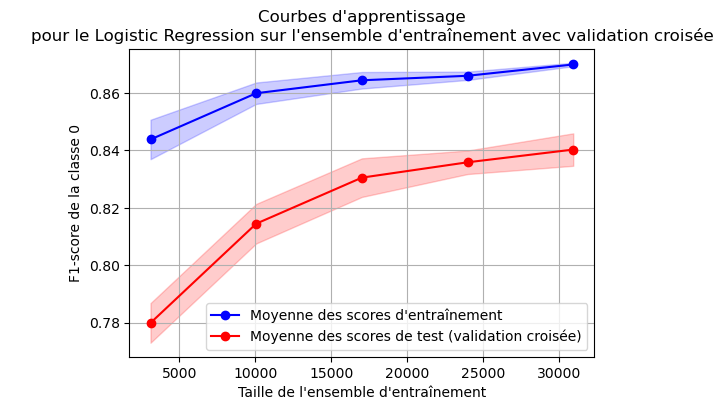

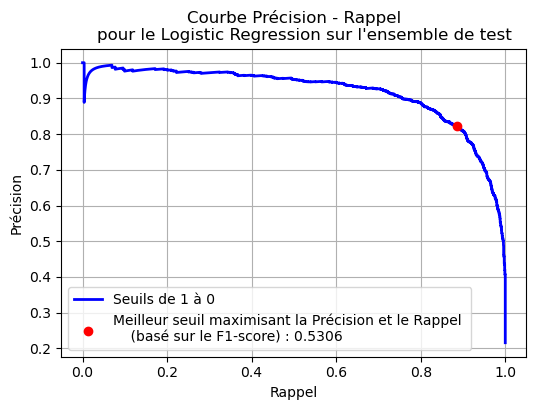

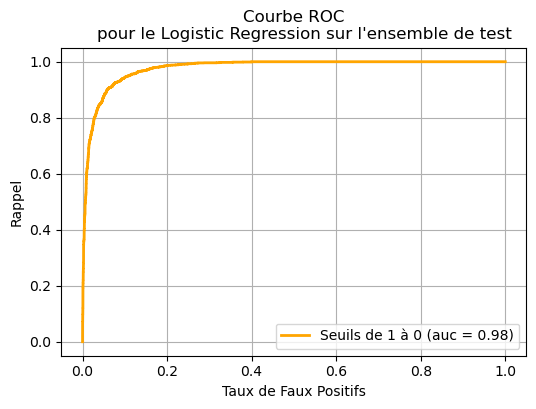

CPU times: user 2.66 s, sys: 662 ms, total: 3.32 s
Wall time: 18.8 s


In [ ]:
%%time

# Courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée et Log dans MLflow
fig = plot_learning_curves(model_name, pipeline_without_sampling, X_train, y_train, stratified_kfold, f1_score_class_0)
run_id = log_artifact(content=fig, filename=f'learning_curves_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe Précision - Rappel sur l'ensemble de test et Log dans MLflow
fig = plot_precision_recall_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'precision_recall_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe ROC sur l'ensemble de test et Log dans MLflow
fig = plot_roc_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'roc_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

In [357]:
# Chargement du meilleur modèle entraîné (format "Joblib")
best_model = joblib.load('../models/logistic_regression_best_model.joblib')

# Chargement du meilleur modèle entraîné (format "Pickle")
#best_model = pickle.load(open('../mlflow/mlruns/393622527853827723/668b7938b90142669ce210f77aaad225/artifacts/model/model.pkl', 'rb'))

In [ ]:
# Variables explicatives les plus / les moins caractéristiques de la classe 0
# (autres formulations : les plus / les moins représentatives ; les plus / les moins associées à)

# Récupération des noms des variables explicatives créées après vectorisation et Ajout des autres variables explicatives
vectorizer = best_model.named_steps['preprocessing'].named_transformers_['vectorizer']
vectorizer_features = vectorizer.get_feature_names_out()
all_features = list(vectorizer_features) + ['characters_count', 'polarity']
# >>> ATTENTION ! <<< l'ordre des features est celui des transformations dans ColumnTransformer de ImbPipeline et non pas celui de X_train

# Récupération des coefficients des variables explicatives
coefs = best_model.named_steps['model'].coef_[0]

# Création d'un DataFrame avec les noms des variables explicatives et les coefficients
df_coefs = pd.DataFrame({'variable explicative': all_features,
                         'coefficient': coefs})

df_coefs_sorted_asc = df_coefs.sort_values(by='coefficient', ascending=True).head(10)
df_coefs_sorted_asc['coefficient'] = df_coefs_sorted_asc['coefficient'].map(lambda x: f'{x:.2f}')

df_coefs_sorted_desc = df_coefs.sort_values(by='coefficient', ascending=False).head(10)
df_coefs_sorted_desc['coefficient'] = df_coefs_sorted_desc['coefficient'].map(lambda x: f'{x:.2f}')

# Affichage
print('\033[1mVariables explicatives les PLUS caractéristiques de la classe 0 :\033[0m')
display(df_coefs_sorted_asc.style.hide(axis='index'))

print('\033[1mVariables explicatives les MOINS caractéristiques de la classe 0 :\033[0m')
display(df_coefs_sorted_desc.style.hide(axis='index'))

# ----------

# Magnitude globale (norme) des coefficients de toutes les variables explicatives et Interception (biais) du modèle

# Calcul de la norme des coefficients du modèle
norm = np.linalg.norm(coefs)

# Récupération de l'interception (biais) du modèle
intercept = best_model.named_steps['model'].intercept_[0]

# Affichage
print(f'Norme des coefficients : {norm:.2f}', f'Interception (biais) : {intercept:.2f}', sep='\n')

Variables explicatives les PLUS caractéristiques de la classe 0 :


Variables explicatives les MOINS caractéristiques de la classe 0 :


Norme des coefficients : 46.72
Interception (biais) : 0.93


In [ ]:
'''
Les variables explicatives avec les coefficients les plus négatifs, comme "fuir" (-7.28), "refuser" (-5.15) ou "impossible" (-4.08), sont les mots
les plus caractéristiques des avis négatifs (classe 0).

À l’inverse, les variables explicatives avec les coefficients les plus positifs, telles que "rapide" (7.18), "facile" (5.71) ou "satisfait" (5.63), sont les mots
les plus caractéristiques des avis positifs (classe 1).

Le modèle Logistic Regression capture bien le vocabulaire typique des sentiments exprimés dans les avis clients.
'''

#### SVC

In [89]:
# Création d'une grille de recherche
param_grid = {
    'preprocessing__vectorizer': [CountVectorizer(min_df=7), TfidfVectorizer(min_df=7)],
    'preprocessing__scaler': [StandardScaler(), RobustScaler()],
    'model__C': [0.1, 1.0, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale'],
    'model__class_weight': [None, 'balanced']
    }

In [90]:
%%time
start_time = time.perf_counter()

model_name = 'SVC'
run_name = 'svc'

# Création d'un pipeline dans une GridSearchCV
grid = create_pipeline_grid(
    SVC(probability=True, random_state=42),
    param_grid,
    y_train
    )

# Entraînement de la GridSearchCV et Affichage des résultats
trained_grid, cv_results = fit_grid_display_results(
    model_name.upper(),
    grid,
    param_grid,
    X_train,
    y_train,
    common_cols_cv_results
    )

# Prédiction avec la GridSearchCV entraînée et Affichage des résultats
y_pred = predict_grid_display_results(
    trained_grid,
    X_test,
    y_test
    )

end_time = time.perf_counter()

# Log des résultats dans MLflow
run_id = mlflow_log(
    run_name,
    trained_grid,
    cv_results,
    y_test,
    y_pred
    )

# Calcul et Affichage de la durée approximative de l'entraînement et de la prédiction
print()
print(f'\033[1mDurée approximative de l\'entraînement et de la prédiction :\033[0m {compute_duration(start_time, end_time)[0]}', end='\n\n')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[CV 2/5; 1/48] START model__C=0.1, model__class_weight=None, model__gamma=scale, model__kernel=linear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 1/5; 1/48] START model__C=0.1, model__class_weight=None, model__gamma=scale, model__kernel=linear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 3/5; 1/48] START model__C=0.1, model__class_weight=None, model__gamma=scale, model__kernel=linear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 4/5; 1/48] START model__C=0.1, model__class_weight=None, model__gamma=scale, model__kernel=linear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 5/5; 1/48] START model__C=0.1, model__class_weight=None, model__gamma=scale, model__kernel=linear, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 1/5; 2/48] START mode

'----------------------------------------------------------------------------------------------------'

SVC

Résultats de la GridSearchCV sur l'ensemble d'entraînement :


Meilleurs hyperparamètres de la GridSearchCV sur l'ensemble d'entraînement :
{'model__C': 1.0, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf', 'preprocessing__scaler': StandardScaler(), 'preprocessing__vectorizer': TfidfVectorizer(min_df=7)}

Meilleur F1-score pour la classe 0 : 0.847            avec un écart-type de : 0.0049

Rapport de classification du Meilleur modèle sur l'ensemble de test :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.91      0.94      0.85      0.92      0.85      2084
          1       0.97      0.94      0.91      0.96      0.92      0.85      7580

avg / total       0.94      0.93      0.91      0.93      0.92      0.85      9664

Matrice de confusion du Meilleur modèle sur l'ensemble de test :


Classes prédites     0     1
Classes réelles             
0                 1889   195
1                  471  7109

2025/05/19 18:54:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Durée approximative de l'entraînement et de la prédiction : 8 h 2 min 42 s

CPU times: user 6min 45s, sys: 37.2 s, total: 7min 22s
Wall time: 8h 32min 9s


Successfully registered model 'svc_best_model'.
Created version '1' of model 'svc_best_model'.


In [91]:
# Création d'un pipeline sans rééchantillonnage et avec les Meilleurs hyperparamètres (avec rééchantillonnage, cela pose un pb sur les petits sous-ensembles car le taux de rééchantillonnage est fixe (à 1.5))
pipeline_without_sampling = ImbPipeline([
    ('preprocessing', ColumnTransformer(transformers=[
        ('vectorizer', TfidfVectorizer(min_df=7), 'cleaned_review'),
        ('scaler', StandardScaler(), ['characters_count', 'polarity'])
    ])),
    ('model', SVC(random_state=42))
    ]).set_params(**trained_grid.best_params_)

# Création des plis stratifiés
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Création du scorer
f1_score_class_0 = make_scorer(score_func=f1_score, pos_label=0)

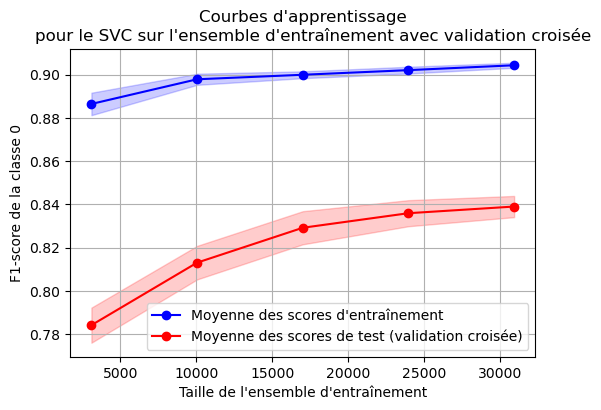

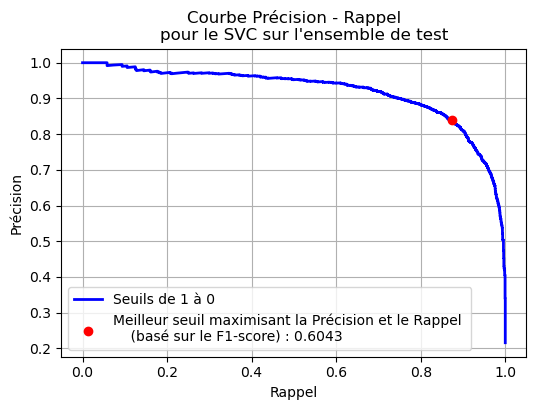

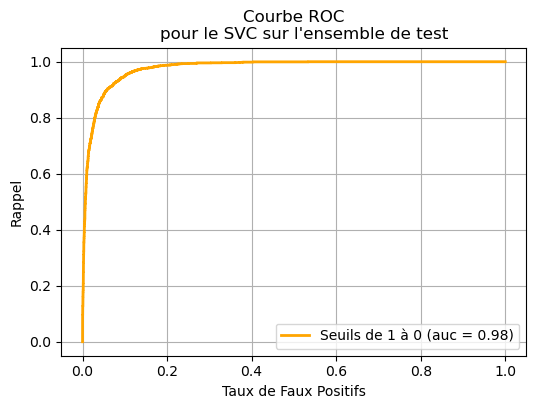

CPU times: user 33.7 s, sys: 1.51 s, total: 35.2 s
Wall time: 5min 7s


In [92]:
%%time

# Courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée et Log dans MLflow
fig = plot_learning_curves(model_name, pipeline_without_sampling, X_train, y_train, stratified_kfold, f1_score_class_0)
run_id = log_artifact(content=fig, filename=f'learning_curves_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe Précision - Rappel sur l'ensemble de test et Log dans MLflow
fig = plot_precision_recall_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'precision_recall_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe ROC sur l'ensemble de test et Log dans MLflow
fig = plot_roc_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'roc_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

#### KNN

In [19]:
# Création d'une grille de recherche
param_grid = {
    'preprocessing__vectorizer': [CountVectorizer(min_df=7), TfidfVectorizer(min_df=7)],
    'preprocessing__scaler': [StandardScaler(), RobustScaler()],
    'model__n_neighbors': [3, 5, 7, 9],
    'model__metric': ['euclidean', 'manhattan'],
    'model__weights': ['uniform', 'distance']
    }

In [94]:
%%time
start_time = time.perf_counter()

model_name = 'KNN'
run_name = 'knn'

# Création d'un pipeline dans une GridSearchCV
grid = create_pipeline_grid(
    KNeighborsClassifier(),
    param_grid,
    y_train
    )

# Entraînement de la GridSearchCV et Affichage des résultats
trained_grid, cv_results = fit_grid_display_results(
    model_name.upper(),
    grid,
    param_grid,
    X_train,
    y_train,
    common_cols_cv_results
    )

# Prédiction avec la GridSearchCV entraînée et Affichage des résultats
y_pred = predict_grid_display_results(
    trained_grid,
    X_test,
    y_test
    )

end_time = time.perf_counter()

# Log des résultats dans MLflow
run_id = mlflow_log(
    run_name,
    trained_grid,
    cv_results,
    y_test,
    y_pred
    )

# Calcul et Affichage de la durée approximative de l'entraînement et de la prédiction
print()
print(f'\033[1mDurée approximative de l\'entraînement et de la prédiction :\033[0m {compute_duration(start_time, end_time)[0]}', end='\n\n')

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START model__metric=euclidean, model__n_neighbors=3, model__weights=uniform, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 2/5; 2/64] START model__metric=euclidean, model__n_neighbors=3, model__weights=uniform, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)
[CV 5/5; 1/64] START model__metric=euclidean, model__n_neighbors=3, model__weights=uniform, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 3/5; 2/64] START model__metric=euclidean, model__n_neighbors=3, model__weights=uniform, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)
[CV 4/5; 1/64] START model__metric=euclidean, model__n_neighbors=3, model__weights=uniform, preprocessing__scaler=StandardScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 1/5; 2/64] STA

'----------------------------------------------------------------------------------------------------'

KNN

Résultats de la GridSearchCV sur l'ensemble d'entraînement :


Meilleurs hyperparamètres de la GridSearchCV sur l'ensemble d'entraînement :
{'model__metric': 'euclidean', 'model__n_neighbors': 9, 'model__weights': 'uniform', 'preprocessing__scaler': RobustScaler(), 'preprocessing__vectorizer': TfidfVectorizer(min_df=7)}

Meilleur F1-score pour la classe 0 : 0.7589            avec un écart-type de : 0.0053

Rapport de classification du Meilleur modèle sur l'ensemble de test :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.76      0.93      0.76      0.84      0.70      2084
          1       0.93      0.93      0.76      0.93      0.84      0.72      7580

avg / total       0.90      0.90      0.80      0.90      0.84      0.72      9664

Matrice de confusion du Meilleur modèle sur l'ensemble de test :


Classes prédites     0     1
Classes réelles             
0                 1593   491
1                  521  7059

2025/05/20 11:36:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Durée approximative de l'entraînement et de la prédiction : 40 min 7 s

CPU times: user 28 s, sys: 15.6 s, total: 43.6 s
Wall time: 40min 14s


Successfully registered model 'knn_best_model'.
Created version '1' of model 'knn_best_model'.


In [95]:
# Création d'un pipeline sans rééchantillonnage et avec les Meilleurs hyperparamètres (avec rééchantillonnage, cela pose un pb sur les petits sous-ensembles car le taux de rééchantillonnage est fixe (à 1.5))
pipeline_without_sampling = ImbPipeline([
    ('preprocessing', ColumnTransformer(transformers=[
        ('vectorizer', TfidfVectorizer(min_df=7), 'cleaned_review'),
        ('scaler', RobustScaler(), ['characters_count', 'polarity'])
    ])),
    ('model', KNeighborsClassifier())
    ]).set_params(**trained_grid.best_params_)

# Création des plis stratifiés
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Création du scorer
f1_score_class_0 = make_scorer(score_func=f1_score, pos_label=0)

/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


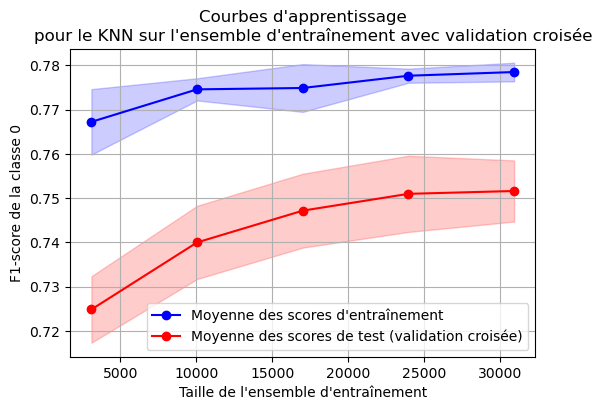

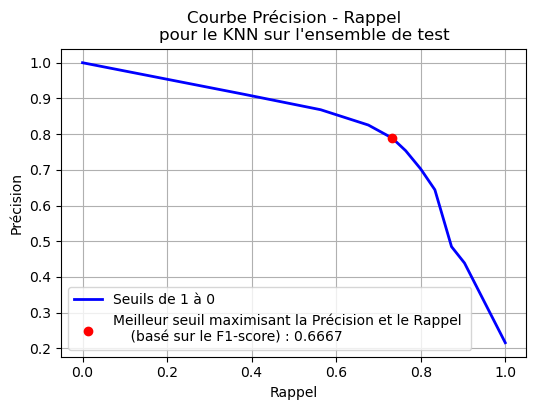

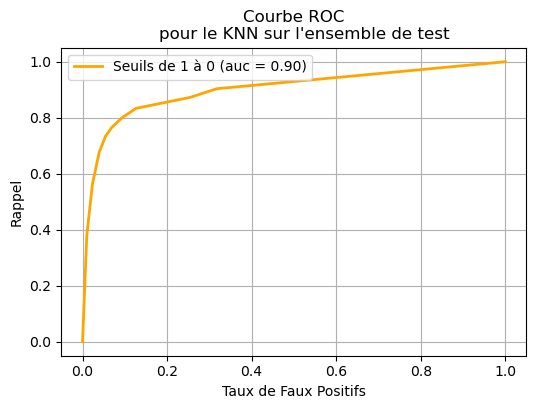

CPU times: user 25.6 s, sys: 7.25 s, total: 32.9 s
Wall time: 3min 54s


In [96]:
%%time

# Courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée et Log dans MLflow
fig = plot_learning_curves(model_name, pipeline_without_sampling, X_train, y_train, stratified_kfold, f1_score_class_0)
run_id = log_artifact(content=fig, filename=f'learning_curves_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe Précision - Rappel sur l'ensemble de test et Log dans MLflow
fig = plot_precision_recall_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'precision_recall_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe ROC sur l'ensemble de test et Log dans MLflow
fig = plot_roc_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'roc_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

#### MULTINOMIALNB

In [ ]:
# Création d'une grille de recherche
param_grid = {
    'preprocessing__vectorizer': [CountVectorizer(min_df=7), TfidfVectorizer(min_df=7)],
    'preprocessing__scaler': [MinMaxScaler()],                                             # Les valeurs doivent être positives d'où le fait de ne pas utiliser un StandardScaler ou un RobustScaler ici
    'model__alpha': [0.1, 1.0, 10],
    'model__fit_prior': [True, False]
    }

In [21]:
%%time
start_time = time.perf_counter()

model_name = 'MultinomialNB'
run_name = 'multinomialnb'

# Création d'un pipeline dans une GridSearchCV
grid = create_pipeline_grid(
    MultinomialNB(),
    param_grid,
    y_train
    )

# Entraînement de la GridSearchCV et Affichage des résultats
trained_grid, cv_results = fit_grid_display_results(
    model_name.upper(),
    grid,
    param_grid,
    X_train,
    y_train,
    common_cols_cv_results
    )

# Prédiction avec la GridSearchCV entraînée et Affichage des résultats
y_pred = predict_grid_display_results(
    trained_grid,
    X_test,
    y_test
    )

end_time = time.perf_counter()

# Log des résultats dans MLflow
run_id = mlflow_log(
    run_name,
    trained_grid,
    cv_results,
    y_test,
    y_pred
    )

# Calcul et Affichage de la durée approximative de l'entraînement et de la prédiction
print()
print(f'\033[1mDurée approximative de l\'entraînement et de la prédiction :\033[0m {compute_duration(start_time, end_time)[0]}', end='\n\n')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 2/5; 1/12] START model__alpha=0.1, model__fit_prior=True, preprocessing__scaler=MinMaxScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 1/5; 1/12] START model__alpha=0.1, model__fit_prior=True, preprocessing__scaler=MinMaxScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 3/5; 1/12] START model__alpha=0.1, model__fit_prior=True, preprocessing__scaler=MinMaxScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 4/5; 1/12] START model__alpha=0.1, model__fit_prior=True, preprocessing__scaler=MinMaxScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 5/5; 1/12] START model__alpha=0.1, model__fit_prior=True, preprocessing__scaler=MinMaxScaler(), preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 1/5; 2/12] START model__alpha=0.1, model__fit_prior=True, preprocessing__scaler=MinMaxScaler(), preprocessing__vectorizer=TfidfVectorizer(min_df=7)
[CV 2/5; 2/12] START model_

'----------------------------------------------------------------------------------------------------'

MULTINOMIALNB

Résultats de la GridSearchCV sur l'ensemble d'entraînement :


Meilleurs hyperparamètres de la GridSearchCV sur l'ensemble d'entraînement :
{'model__alpha': 10, 'model__fit_prior': True, 'preprocessing__scaler': MinMaxScaler(), 'preprocessing__vectorizer': TfidfVectorizer(min_df=7)}

Meilleur F1-score pour la classe 0 : 0.8405            avec un écart-type de : 0.0077

Rapport de classification du Meilleur modèle sur l'ensemble de test :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.86      0.95      0.84      0.90      0.80      2084
          1       0.96      0.95      0.86      0.95      0.90      0.82      7580

avg / total       0.93      0.93      0.88      0.93      0.90      0.82      9664

Matrice de confusion du Meilleur modèle sur l'ensemble de test :


Classes prédites     0     1
Classes réelles             
0                 1783   301
1                  381  7199

2025/05/20 14:07:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Durée approximative de l'entraînement et de la prédiction : 0 min 16 s

CPU times: user 3.11 s, sys: 1.49 s, total: 4.6 s
Wall time: 23.9 s


Registered model 'multinomialnb_best_model' already exists. Creating a new version of this model...
Created version '4' of model 'multinomialnb_best_model'.


In [22]:
# Création d'un pipeline sans rééchantillonnage et avec les Meilleurs hyperparamètres (avec rééchantillonnage, cela pose un pb sur les petits sous-ensembles car le taux de rééchantillonnage est fixe (à 1.5))
pipeline_without_sampling = ImbPipeline([
    ('preprocessing', ColumnTransformer(transformers=[
        ('vectorizer', TfidfVectorizer(min_df=7), 'cleaned_review'),
        ('scaler', MinMaxScaler(), ['characters_count', 'polarity'])
    ])),
    ('model', MultinomialNB())
    ]).set_params(**trained_grid.best_params_)

# Création des plis stratifiés
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Création du scorer
f1_score_class_0 = make_scorer(score_func=f1_score, pos_label=0)

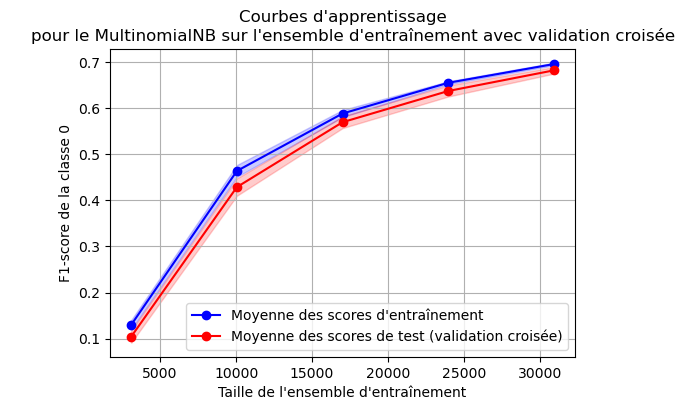

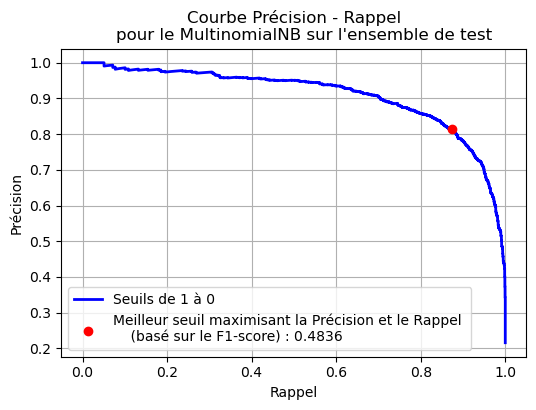

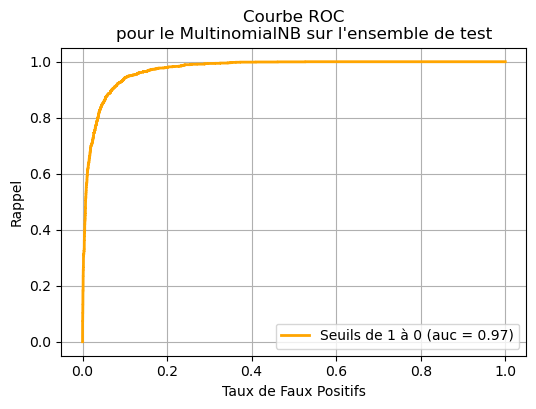

CPU times: user 2.25 s, sys: 692 ms, total: 2.94 s
Wall time: 6.36 s


In [23]:
%%time

# Courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée et Log dans MLflow
fig = plot_learning_curves(model_name, pipeline_without_sampling, X_train, y_train, stratified_kfold, f1_score_class_0)
run_id = log_artifact(content=fig, filename=f'learning_curves_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe Précision - Rappel sur l'ensemble de test et Log dans MLflow
fig = plot_precision_recall_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'precision_recall_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe ROC sur l'ensemble de test et Log dans MLflow
fig = plot_roc_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'roc_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

In [16]:
# Chargement du meilleur modèle entraîné (format "Joblib")
best_model = joblib.load('../models/multinomialnb_best_model.joblib')

# Chargement du meilleur modèle entraîné (format "Pickle")
#best_model = pickle.load(open('../mlflow/mlruns/393622527853827723/ffd40b526edc4860b77570511e500adc/artifacts/model/model.pkl', 'rb'))

In [17]:
# Variables explicatives ayant les poids les plus forts / les plus faibles en faveur de la classe 0
# (autres formulations : les plus / les moins associées à la classe 0)

# Récupération des noms des variables explicatives créées après vectorisation et Ajout des autres variables explicatives
vectorizer = best_model.named_steps['preprocessing'].named_transformers_['vectorizer']
vectorizer_features = vectorizer.get_feature_names_out()
all_features = list(vectorizer_features) + ['characters_count', 'polarity']
# >>> ATTENTION ! <<< l'ordre des features est celui des transformations dans ColumnTransformer de ImbPipeline et non pas celui de X_train

# Récupération des log-proba conditionnelles des variables explicatives pour la classe 0 (mot | classe 0)
log_proba_class_0 = best_model.named_steps['model'].feature_log_prob_[0]

# Création d'un DataFrame avec les noms des variables explicatives, les log-proba conditionnelles et les proba conditionnelles (mot | classe 0)
df_log_proba = pd.DataFrame({'variable explicative': all_features,
                             'log-proba conditionnelle pour la classe 0': log_proba_class_0,
                             'proba conditionnelle pour la classe 0 (en %)': np.exp(log_proba_class_0)})

df_log_proba_sorted_desc = df_log_proba.sort_values(by='log-proba conditionnelle pour la classe 0', ascending=False).head(10)
df_log_proba_sorted_desc['log-proba conditionnelle pour la classe 0'] = df_log_proba_sorted_desc['log-proba conditionnelle pour la classe 0'].map(lambda x: f'{x:.2f}')
df_log_proba_sorted_desc['proba conditionnelle pour la classe 0 (en %)'] = df_log_proba_sorted_desc['proba conditionnelle pour la classe 0 (en %)'].map(lambda x: f'{x * 100:.2f}')

df_log_proba_sorted_asc = df_log_proba.sort_values(by='log-proba conditionnelle pour la classe 0', ascending=True).head(10)
df_log_proba_sorted_asc['log-proba conditionnelle pour la classe 0'] = df_log_proba_sorted_asc['log-proba conditionnelle pour la classe 0'].map(lambda x: f'{x:.2f}')
df_log_proba_sorted_asc['proba conditionnelle pour la classe 0 (en %)'] = df_log_proba_sorted_asc['proba conditionnelle pour la classe 0 (en %)'].map(lambda x: f'{x * 100:.2f}')

# Affichage
print('\033[1mVariables explicatives ayant les poids les PLUS FORTS en faveur de la classe 0 :\033[0m',
      '(>>> Attention <<< : "polarity" et "characters_count" ne sont pas des comptages de mots ;',
      'leur log-proba ne s’interprète pas comme celui des mots vectorisés)', sep='\n')
display(df_log_proba_sorted_desc.style.hide(axis='index'))

print('\033[1mVariables explicatives ayant les poids les PLUS FAIBLES en faveur de la classe 0 :\033[0m')
display(df_log_proba_sorted_asc.style.hide(axis='index'))

Variables explicatives ayant les poids les PLUS FORTS en faveur de la classe 0 :
(>>> Attention <<< : "polarity" et "characters_count" ne sont pas des comptages de mots ;
leur log-proba ne s’interprète pas comme celui des mots vectorisés)


Variables explicatives ayant les poids les PLUS FAIBLES en faveur de la classe 0 :


In [ ]:
'''
Les variables explicatives avec les log-proba les plus élevés pour la classe 0, comme "compte" (-4.76), "client" (-5.03) ou "service" (-5.19), sont les mots
les plus associés aux avis négatifs (classe 0).

À l’inverse, les variables explicatives avec les log-proba les plus faibles pour la classe 0, telles que "reactive" (-9.21), "efficacite" (-9.21) ou "rapid" (-9.21), sont les mots
les plus associés aux avis positifs (classe 1).

Le modèle MultinomialNB reflète bien l'affinité conditionnelle des variables aux avis négatifs.
'''

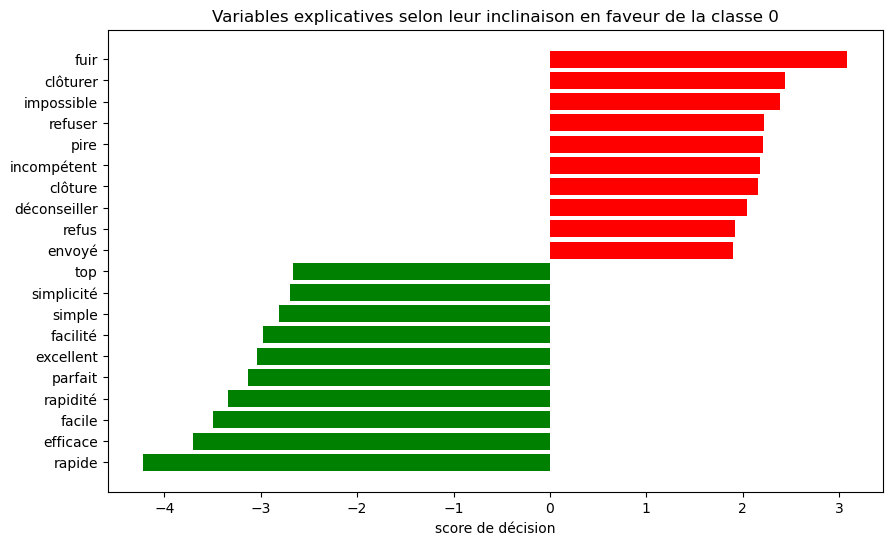

In [ ]:
# Variables explicatives selon leur inclinaison (score de décision) en faveur de la classe 0
# (autres formulations : les plus / les moins associées à)

# Calcul des différences des log probas entre la classe 0 et la classe 1
log_proba_class_0 = best_model.named_steps['model'].feature_log_prob_[0]
log_proba_class_1 = best_model.named_steps['model'].feature_log_prob_[1]
diff_0_1 = log_proba_class_0 - log_proba_class_1

# Création d'un DataFrame avec les noms des variables explicatives et les différences des log proba entre la classe 0 et la classe 1
df_diff = pd.DataFrame({'variable explicative': all_features,
                        'score de décision': diff_0_1}) \
.sort_values(by='score de décision', ascending=True)

top_class_1 = df_diff.head(10)
top_class_0 = df_diff.tail(10)

# Affichage
plt.figure(figsize=(10,6))

plt.barh(top_class_1['variable explicative'], top_class_1['score de décision'], color='green')
plt.barh(top_class_0['variable explicative'], top_class_0['score de décision'], color='red')

plt.xlabel('score de décision')
plt.title('Variables explicatives selon leur inclinaison en faveur de la classe 0')

plt.show()

In [ ]:
'''
Les variables explicatives avec les scores de décision les plus positifs, comme "fuir", "clôturer" ou "impossible", sont les mots
qui penchent le plus en faveur de la classe 0 (avis négatifs).

À l’inverse, les variables explicatives avec les scores de décision les plus négatifs, comme "rapide", "efficace" ou "facile", sont les mots
qui sont plus fortement associés à la classe 1 (avis positifs).
'''

#### DECISION TREE

In [ ]:
# Création d'une grille de recherche
param_grid = {
    'preprocessing__vectorizer': [CountVectorizer(min_df=7), TfidfVectorizer(min_df=7)],
    'preprocessing__scaler': ['passthrough'],                                              # Scaling non nécessaire
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [7, 15, 20],                                                       # Profondeur du Decision Tree
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [2, 5],
    'model__max_features': [None],
    'model__class_weight': [None, 'balanced']
    }

In [32]:
%%time
start_time = time.perf_counter()

model_name = 'Decision Tree'
run_name = 'decision_tree'

# Création d'un pipeline dans une GridSearchCV
grid = create_pipeline_grid(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    y_train
    )

# Entraînement de la GridSearchCV et Affichage des résultats
trained_grid, cv_results = fit_grid_display_results(
    model_name.upper(),
    grid,
    param_grid,
    X_train,
    y_train,
    common_cols_cv_results
    )

# Prédiction avec la GridSearchCV entraînée et Affichage des résultats
y_pred = predict_grid_display_results(
    trained_grid,
    X_test,
    y_test
    )

end_time = time.perf_counter()

# Log des résultats dans MLflow
run_id = mlflow_log(
    run_name,
    trained_grid,
    cv_results,
    y_test,
    y_pred
    )

# Calcul et Affichage de la durée approximative de l'entraînement et de la prédiction
print()
print(f'\033[1mDurée approximative de l\'entraînement et de la prédiction :\033[0m {compute_duration(start_time, end_time)[0]}', end='\n\n')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5; 2/96] START model__class_weight=None, model__criterion=gini, model__max_depth=7, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, preprocessing__scaler=passthrough, preprocessing__vectorizer=TfidfVectorizer(min_df=7)
[CV 1/5; 1/96] START model__class_weight=None, model__criterion=gini, model__max_depth=7, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, preprocessing__scaler=passthrough, preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 2/5; 1/96] START model__class_weight=None, model__criterion=gini, model__max_depth=7, model__max_features=None, model__min_samples_leaf=2, model__min_samples_split=5, preprocessing__scaler=passthrough, preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 5/5; 1/96] START model__class_weight=None, model__criterion=gini, model__max_depth=7, model__max_features=None, model__min_samples_leaf=2, model__min_samples_sp

'----------------------------------------------------------------------------------------------------'

DECISION TREE

Résultats de la GridSearchCV sur l'ensemble d'entraînement :


Meilleurs hyperparamètres de la GridSearchCV sur l'ensemble d'entraînement :
{'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 15, 'model__max_features': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'preprocessing__scaler': 'passthrough', 'preprocessing__vectorizer': TfidfVectorizer(min_df=7)}

Meilleur F1-score pour la classe 0 : 0.7422            avec un écart-type de : 0.01

Rapport de classification du Meilleur modèle sur l'ensemble de test :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.68      0.79      0.90      0.73      0.84      0.71      2084
          1       0.94      0.90      0.79      0.92      0.84      0.72      7580

avg / total       0.89      0.88      0.82      0.88      0.84      0.72      9664

Matrice de confusion du Meilleur modèle sur l'ensemble de test :


Classes prédites     0     1
Classes réelles             
0                 1654   430
1                  766  6814

2025/05/20 14:38:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'decision_tree_best_model'.
Created version '1' of model 'decision_tree_best_model'.



Durée approximative de l'entraînement et de la prédiction : 2 min 34 s

CPU times: user 12.8 s, sys: 6.23 s, total: 19 s
Wall time: 2min 40s


In [ ]:
# Création d'un pipeline sans rééchantillonnage et scaler et avec les Meilleurs hyperparamètres (avec rééchantillonnage, cela pose un pb sur les petits sous-ensembles car le taux de rééchantillonnage est fixe (à 1.5))
pipeline_without_sampling = ImbPipeline([
    ('preprocessing', ColumnTransformer(transformers=[
        ('vectorizer', TfidfVectorizer(min_df=7), 'cleaned_review'),
        ('scaler', 'passthrough', ['characters_count', 'polarity'])
    ])),
    ('model', DecisionTreeClassifier(random_state=42))
    ]).set_params(**trained_grid.best_params_)

# Création des plis stratifiés
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Création du scorer
f1_score_class_0 = make_scorer(score_func=f1_score, pos_label=0)

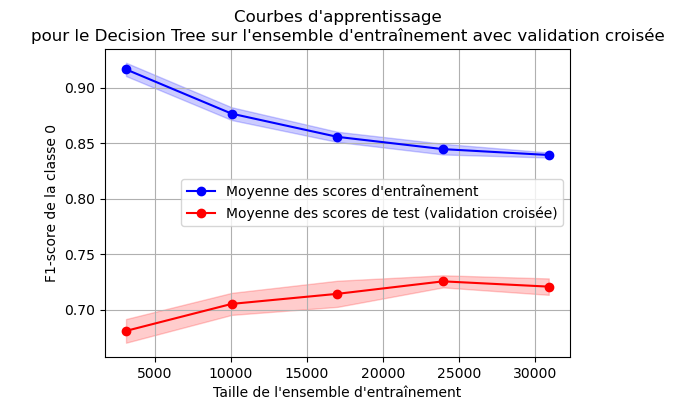

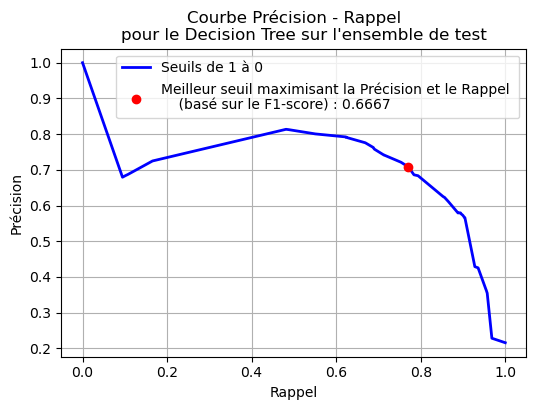

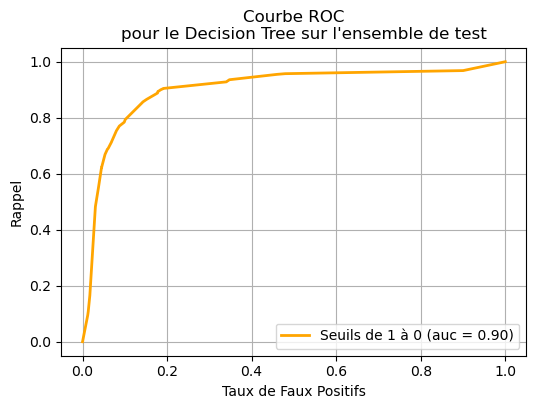

CPU times: user 2.18 s, sys: 833 ms, total: 3.01 s
Wall time: 13.5 s


In [35]:
%%time

# Courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée et Log dans MLflow
fig = plot_learning_curves(model_name, pipeline_without_sampling, X_train, y_train, stratified_kfold, f1_score_class_0)
run_id = log_artifact(content=fig, filename=f'learning_curves_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe Précision - Rappel sur l'ensemble de test et Log dans MLflow
fig = plot_precision_recall_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'precision_recall_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe ROC sur l'ensemble de test et Log dans MLflow
fig = plot_roc_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'roc_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

In [18]:
# Chargement du meilleur modèle entraîné (format "Joblib")
best_model = joblib.load('../models/decision_tree_best_model.joblib')

# Chargement du meilleur modèle entraîné (format "Pickle")
#best_model = pickle.load(open('../mlflow/mlruns/393622527853827723/ad3de77a79f84089b962b942a895841c/artifacts/model/model.pkl', 'rb'))

In [19]:
# Variables explicatives les plus discriminantes dans le modèle
# (autres formulations : les plus importantes ; ayant la plus forte contribution au modèle ; ayant le plus grand poids dans le modèle)

# Récupération des noms des variables explicatives créées après vectorisation et Ajout des autres variables explicatives
vectorizer = best_model.named_steps['preprocessing'].named_transformers_['vectorizer']
vectorizer_features = vectorizer.get_feature_names_out()
all_features = list(vectorizer_features) + ['characters_count', 'polarity']
# >>> ATTENTION ! <<< l'ordre des features est celui des transformations dans ColumnTransformer de ImbPipeline et non pas celui de X_train

# Récupération des importances des variables explicatives
importances = best_model.named_steps['model'].feature_importances_

# Création d'un DataFrame avec les noms des variables explicatives et les importances
df_importances = pd.DataFrame({'variable explicative': all_features,
                               'importance': importances,
                               'pourcentage de l\'importance (en %)': importances * 100})

df_importances_sorted_desc = df_importances.sort_values(by='importance', ascending=False).head(10)
df_importances_sorted_desc['importance'] = df_importances_sorted_desc['importance'].map(lambda x: f'{x:.4f}')
df_importances_sorted_desc['pourcentage de l\'importance (en %)'] = df_importances_sorted_desc['pourcentage de l\'importance (en %)'].map(lambda x: f'{x:.2f}')

# Affichage
print('\033[1mVariables explicatives les PLUS discriminantes dans le modèle :\033[0m')
display(df_importances_sorted_desc.style.hide(axis='index'))

Variables explicatives les PLUS discriminantes dans le modèle :


In [ ]:
'''
Les variables explicatives les plus discriminantes dans le modèle sont "characters_count" (50.03 %) et "polarity" (24.51 %), et à plus faible contribution,
des mots comme "fuir" (2.06 %), "satisfait" (1.32 %) ou "facile" (0.98 %).

Ces variables explicatives jouent un rôle majeur dans la capacité du modèle Decision Tree à différencier les classes.
'''

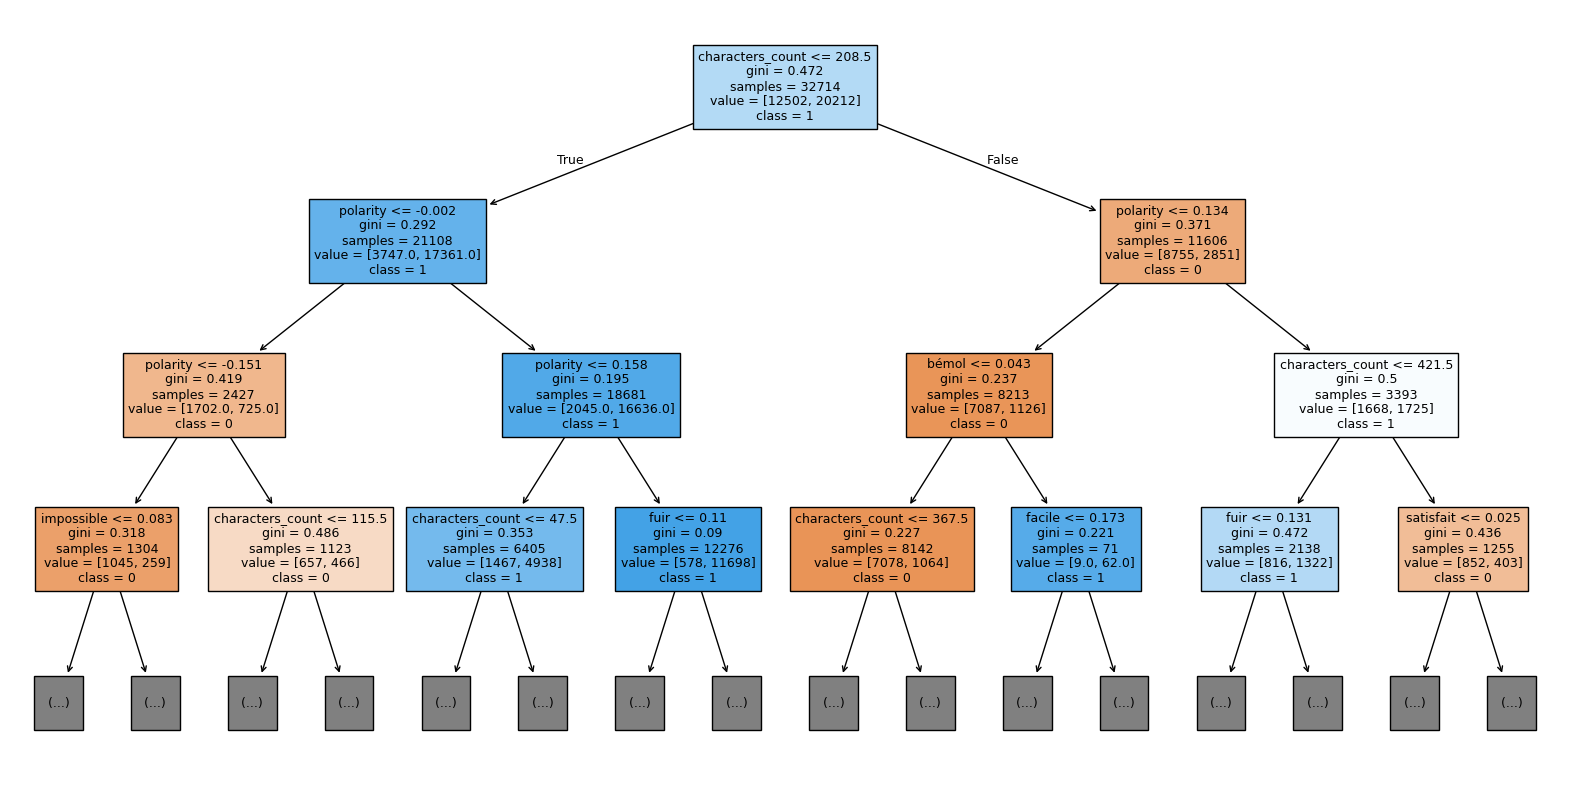

In [33]:
# Affichage de l'arbre de décision du modèle entraîné
plt.figure(figsize=(20,10))

plot_tree(best_model.named_steps['model'], max_depth=3, feature_names=all_features, class_names=['0', '1'], filled=True, fontsize=9)

plt.show()

In [ ]:
'''
L’arbre de décision s’appuie principalement sur les variables "characters_count" et "polarity", ainsi que sur plusieurs mots comme "impossible", "satisfait" ou "bémol",
pour distinguer les classes.

Le premier critère de séparation repose sur la longueur de l’avis (characters_count > 208.5).
- Les avis les plus longs sont associés à la classe 0 (avis négatifs),
- tandis que les plus courts sont rattachés à la classe 1 (avis positifs).

Ensuite, "polarity" affine cette première séparation : une polarité plus négative oriente davantage vers la classe 0.

À noter : ces deux tendances avaient déjà été identifiées dans les analyses statistiques préalables. (Cf. notebook précedent)

Enfin, les mots comme "impossible", "satisfait" (étonnemment... à investiguer), interviennent dans les derniers noeuds affichés, pour cibler encore plus précisément les avis négatifs.
'''

#### RANDOM FOREST

In [ ]:
# Création d'une grille de recherche
param_grid = {
    'preprocessing__vectorizer': [CountVectorizer(min_df=7), TfidfVectorizer(min_df=7)],
    'preprocessing__scaler': ['passthrough'],                                              # Scaling non nécessaire
    'model__n_estimators': [50, 100],                                                      # Nombre de Decision Trees
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [7, 15, 20],                                                       # Profondeur des Decision Trees
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [2, 5],
    'model__max_features': ['sqrt'],
    'model__class_weight': [None, 'balanced']
    }

In [ ]:
%%time
start_time = time.perf_counter()

model_name = 'Random Forest'
run_name = 'random_forest'

# Création d'un pipeline dans une GridSearchCV
grid = create_pipeline_grid(
    RandomForestClassifier(random_state=42),
    param_grid,
    y_train
    )

# Entraînement de la GridSearchCV et Affichage des résultats
trained_grid, cv_results = fit_grid_display_results(
    model_name.upper(),
    grid,
    param_grid,
    X_train,
    y_train,
    common_cols_cv_results
    )

# Prédiction avec la GridSearchCV entraînée et Affichage des résultats
y_pred = predict_grid_display_results(
    trained_grid,
    X_test,
    y_test
    )

end_time = time.perf_counter()

# Log des résultats dans MLflow
run_id = mlflow_log(
    run_name,
    trained_grid,
    cv_results,
    y_test,
    y_pred
    )

# Calcul et Affichage de la durée approximative de l'entraînement et de la prédiction
print()
print(f'\033[1mDurée approximative de l\'entraînement et de la prédiction :\033[0m {compute_duration(start_time, end_time)[0]}', end='\n\n')

In [42]:
# Création d'un pipeline sans rééchantillonnage et scaler et avec les Meilleurs hyperparamètres (avec rééchantillonnage, cela pose un pb sur les petits sous-ensembles car le taux de rééchantillonnage est fixe (à 1.5))
pipeline_without_sampling = ImbPipeline([
    ('preprocessing', ColumnTransformer(transformers=[
        ('vectorizer', CountVectorizer(min_df=7), 'cleaned_review'),
        ('scaler', 'passthrough', ['characters_count', 'polarity'])
    ])),
    ('model', RandomForestClassifier(random_state=42))
    ]).set_params(**trained_grid.best_params_)

# Création des plis stratifiés
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Création du scorer
f1_score_class_0 = make_scorer(score_func=f1_score, pos_label=0)

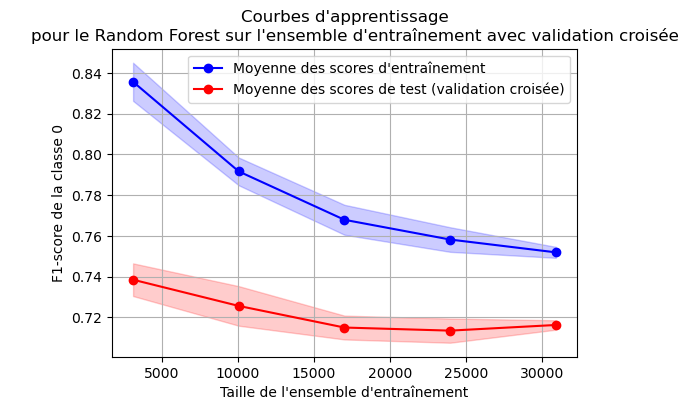

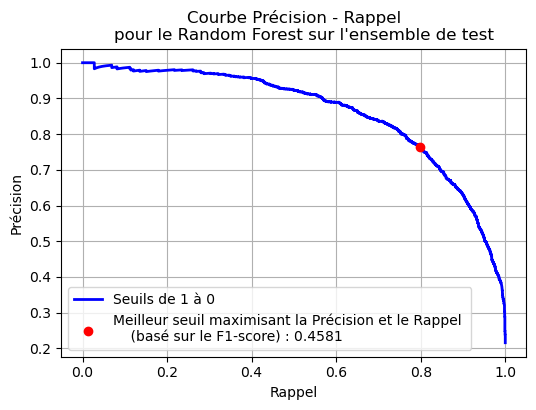

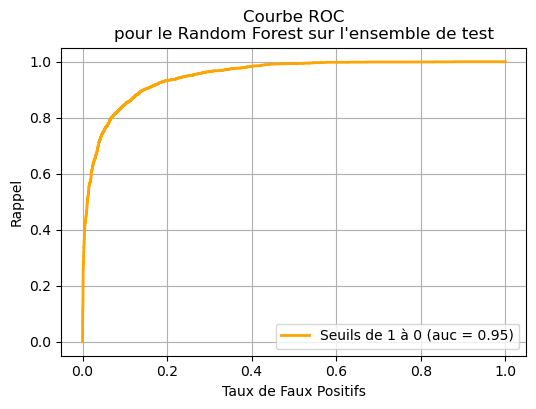

CPU times: user 2.41 s, sys: 883 ms, total: 3.3 s
Wall time: 19.4 s


In [43]:
%%time

# Courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée et Log dans MLflow
fig = plot_learning_curves(model_name, pipeline_without_sampling, X_train, y_train, stratified_kfold, f1_score_class_0)
run_id = log_artifact(content=fig, filename=f'learning_curves_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe Précision - Rappel sur l'ensemble de test et Log dans MLflow
fig = plot_precision_recall_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'precision_recall_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe ROC sur l'ensemble de test et Log dans MLflow
fig = plot_roc_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'roc_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

In [44]:
# Variables explicatives ayant le plus de poids dans la prédiction de la classe 0
vectorizer = trained_grid.best_estimator_.named_steps['preprocessing'].named_transformers_['vectorizer']
vectorizer_features = vectorizer.get_feature_names_out()
all_features = list(vectorizer_features) + ['characters_count', 'polarity']

coefs = trained_grid.best_estimator_.named_steps['model'].feature_importances_

df_coefs = pd.DataFrame({'feature': all_features, 'feature_importances': coefs})
df_coefs.sort_values(by='feature_importances', ascending=False, inplace=True)

display(df_coefs.head(10))

feature  feature_importances
3796  characters_count             0.101535
3797          polarity             0.089118
706             compte             0.035488
1755        impossible             0.032334
2844            rapide             0.029521
1949              jour             0.029216
1560              fuir             0.028856
614             client             0.028353
2076              mail             0.021214
2223              mois             0.020853

#### BALANCED RANDOM FOREST

In [ ]:
# Création d'une grille de recherche
param_grid = {
    'preprocessing__vectorizer': [CountVectorizer(min_df=7), TfidfVectorizer(min_df=7)],
    'preprocessing__scaler': ['passthrough'],                                              # Scaling non nécessaire
    'oversampler': ['passthrough'],                                                        # Oversampling non nécessaire
    'undersampler': ['passthrough'],                                                       # Undersampling non nécessaire
    'model__n_estimators': [50, 100],                                                      # Nombre de Decision Trees
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [7, 15, 20],                                                       # Profondeur des Decision Trees
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [2, 5],
    'model__max_features': ['sqrt']
    }

In [51]:
%%time
start_time = time.perf_counter()

model_name = 'Balanced Random Forest'
run_name = 'balanced_random_forest'

# Création d'un pipeline dans une GridSearchCV
grid = create_pipeline_grid(
    BalancedRandomForestClassifier(random_state=42),
    param_grid,
    y_train
    )

# Entraînement de la GridSearchCV et Affichage des résultats
trained_grid, cv_results = fit_grid_display_results(
    model_name.upper(),
    grid,
    param_grid,
    X_train,
    y_train,
    common_cols_cv_results
    )

# Prédiction avec la GridSearchCV entraînée et Affichage des résultats
y_pred = predict_grid_display_results(
    trained_grid,
    X_test,
    y_test
    )

end_time = time.perf_counter()

# Log des résultats dans MLflow
run_id = mlflow_log(
    run_name,
    trained_grid,
    cv_results,
    y_test,
    y_pred
    )

# Calcul et Affichage de la durée approximative de l'entraînement et de la prédiction
print()
print(f'\033[1mDurée approximative de l\'entraînement et de la prédiction :\033[0m {compute_duration(start_time, end_time)[0]}', end='\n\n')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 2/5; 1/96] START model__criterion=gini, model__max_depth=7, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=50, oversampler=passthrough, preprocessing__scaler=passthrough, preprocessing__vectorizer=CountVectorizer(min_df=7), undersampler=passthrough
[CV 4/5; 1/96] START model__criterion=gini, model__max_depth=7, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=50, oversampler=passthrough, preprocessing__scaler=passthrough, preprocessing__vectorizer=CountVectorizer(min_df=7), undersampler=passthrough
[CV 5/5; 1/96] START model__criterion=gini, model__max_depth=7, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=50, oversampler=passthrough, preprocessing__scaler=passthrough, preprocessing__vectorizer=CountVectorizer(min_df=7), undersampler=passthrough
[CV 3/5; 1/96] ST

'----------------------------------------------------------------------------------------------------'

BALANCED RANDOM FOREST

Résultats de la GridSearchCV sur l'ensemble d'entraînement :


Meilleurs hyperparamètres de la GridSearchCV sur l'ensemble d'entraînement :
{'model__criterion': 'entropy', 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100, 'oversampler': 'passthrough', 'preprocessing__scaler': 'passthrough', 'preprocessing__vectorizer': CountVectorizer(min_df=7), 'undersampler': 'passthrough'}

Meilleur F1-score pour la classe 0 : 0.7734            avec un écart-type de : 0.0057

Rapport de classification du Meilleur modèle sur l'ensemble de test :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.71      0.84      0.90      0.77      0.87      0.75      2084
          1       0.95      0.90      0.84      0.93      0.87      0.76      7580

avg / total       0.90      0.89      0.85      0.89      0.87      0.76      9664

Matrice de confusion du Meilleur modèle sur l'ensemble de test :


Classes prédites     0     1
Classes réelles             
0                 1746   338
1                  728  6852

2025/05/20 15:47:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Durée approximative de l'entraînement et de la prédiction : 5 min 56 s

CPU times: user 21.4 s, sys: 7.17 s, total: 28.5 s
Wall time: 6min 2s


Registered model 'balanced_random_forest_best_model' already exists. Creating a new version of this model...
Created version '2' of model 'balanced_random_forest_best_model'.


In [52]:
# Création d'un pipeline sans rééchantillonnage et scaler et avec les Meilleurs hyperparamètres (avec rééchantillonnage, cela pose un pb sur les petits sous-ensembles car le taux de rééchantillonnage est fixe (à 1.5))
pipeline_without_sampling = ImbPipeline([
    ('preprocessing', ColumnTransformer(transformers=[
        ('vectorizer', CountVectorizer(min_df=7), 'cleaned_review'),
        ('scaler', 'passthrough', ['characters_count', 'polarity'])
    ])),
    ('oversampler', 'passthrough'),
    ('undersampler', 'passthrough'),
    ('model', BalancedRandomForestClassifier(random_state=42))
    ]).set_params(**trained_grid.best_params_)

# Création des plis stratifiés
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Création du scorer
f1_score_class_0 = make_scorer(score_func=f1_score, pos_label=0)

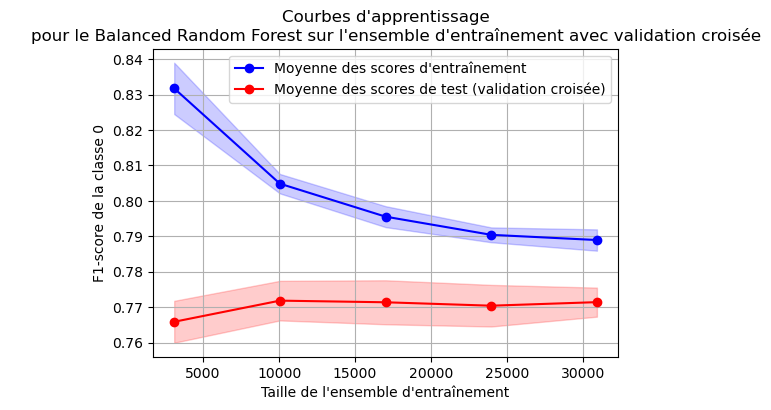

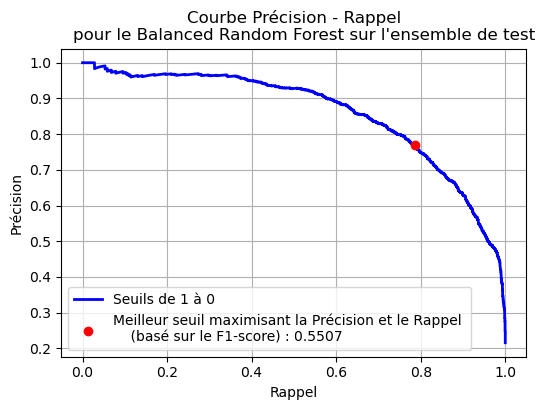

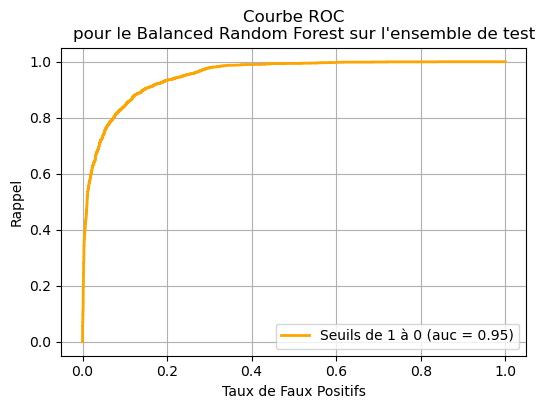

CPU times: user 2.37 s, sys: 551 ms, total: 2.92 s
Wall time: 16.5 s


In [53]:
%%time

# Courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée et Log dans MLflow
fig = plot_learning_curves(model_name, pipeline_without_sampling, X_train, y_train, stratified_kfold, f1_score_class_0)
run_id = log_artifact(content=fig, filename=f'learning_curves_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe Précision - Rappel sur l'ensemble de test et Log dans MLflow
fig = plot_precision_recall_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'precision_recall_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe ROC sur l'ensemble de test et Log dans MLflow
fig = plot_roc_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'roc_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

In [54]:
# Variables explicatives ayant le plus de poids dans la prédiction de la classe 0
vectorizer = trained_grid.best_estimator_.named_steps['preprocessing'].named_transformers_['vectorizer']
vectorizer_features = vectorizer.get_feature_names_out()
all_features = list(vectorizer_features) + ['characters_count', 'polarity']

coefs = trained_grid.best_estimator_.named_steps['model'].feature_importances_

df_coefs = pd.DataFrame({'feature': all_features, 'feature_importances': coefs})
df_coefs.sort_values(by='feature_importances', ascending=False, inplace=True)

display(df_coefs.head(10))

feature  feature_importances
3797          polarity             0.106015
3796  characters_count             0.087920
706             compte             0.034298
2844            rapide             0.031119
614             client             0.027652
1755        impossible             0.023306
1560              fuir             0.022470
302              aucun             0.018211
2076              mail             0.018200
1949              jour             0.017969

#### EASY ENSEMBLE

In [60]:
# Création d'une grille de recherche
param_grid = {
    'preprocessing__vectorizer': [CountVectorizer(min_df=7), TfidfVectorizer(min_df=7)],
    'preprocessing__scaler': ['passthrough'],                                              # Scaling non nécessaire
    'oversampler': ['passthrough'],                                                        # Oversampling non nécessaire
    'undersampler': ['passthrough'],                                                       # Undersampling non nécessaire

    # EasyEnsembleClassifier
    'model__estimator': [AdaBoostClassifier(random_state=42)],
    'model__n_estimators': [10, 30],                                                       # Nombre d'AdaBoosts

    # AdaBoostClassifier
    'model__estimator__estimator': [DecisionTreeClassifier(random_state=42)],
    'model__estimator__n_estimators': [50],                                                # Nombre de Decision Trees
    'model__estimator__learning_rate': [0.5, 1.0],

    # DecisionTreeClassifier (estimator de AdaBoostClassifier)
    'model__estimator__estimator__criterion': ['gini', 'entropy'],
    'model__estimator__estimator__max_depth': [1, 5],
    'model__estimator__estimator__min_samples_split': [5, 10],
    'model__estimator__estimator__min_samples_leaf': [2, 5],
    'model__estimator__estimator__max_features': [None]
    }

In [61]:
%%time
start_time = time.perf_counter()

model_name = 'Easy Ensemble'
run_name = 'easy_ensemble'

# Création d'un pipeline dans une GridSearchCV
grid = create_pipeline_grid(
    EasyEnsembleClassifier(random_state=42),
    param_grid,
    y_train
    )

# Entraînement de la GridSearchCV et Affichage des résultats
trained_grid, cv_results = fit_grid_display_results(
    model_name.upper(),
    grid,
    param_grid,
    X_train,
    y_train,
    common_cols_cv_results
    )

# Prédiction avec la GridSearchCV entraînée et Affichage des résultats
y_pred = predict_grid_display_results(
    trained_grid,
    X_test,
    y_test
    )

end_time = time.perf_counter()

# Log des résultats dans MLflow
run_id = mlflow_log(
    run_name,
    trained_grid,
    cv_results,
    y_test,
    y_pred
    )

# Calcul et Affichage de la durée approximative de l'entraînement et de la prédiction
print()
print(f'\033[1mDurée approximative de l\'entraînement et de la prédiction :\033[0m {compute_duration(start_time, end_time)[0]}', end='\n\n')

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 2/5; 1/128] START model__estimator=AdaBoostClassifier(random_state=42), model__estimator__estimator=DecisionTreeClassifier(random_state=42), model__estimator__estimator__criterion=gini, model__estimator__estimator__max_depth=1, model__estimator__estimator__max_features=None, model__estimator__estimator__min_samples_leaf=2, model__estimator__estimator__min_samples_split=5, model__estimator__learning_rate=0.5, model__estimator__n_estimators=50, model__n_estimators=10, oversampler=passthrough, preprocessing__scaler=passthrough, preprocessing__vectorizer=CountVectorizer(min_df=7), undersampler=passthrough
[CV 1/5; 1/128] START model__estimator=AdaBoostClassifier(random_state=42), model__estimator__estimator=DecisionTreeClassifier(random_state=42), model__estimator__estimator__criterion=gini, model__estimator__estimator__max_depth=1, model__estimator__estimator__max_features=None, model__estimator__estimator__min_samples_lea

'----------------------------------------------------------------------------------------------------'

EASY ENSEMBLE

Résultats de la GridSearchCV sur l'ensemble d'entraînement :


Meilleurs hyperparamètres de la GridSearchCV sur l'ensemble d'entraînement :
{'model__estimator': AdaBoostClassifier(random_state=42), 'model__estimator__estimator': DecisionTreeClassifier(random_state=42), 'model__estimator__estimator__criterion': 'gini', 'model__estimator__estimator__max_depth': 5, 'model__estimator__estimator__max_features': None, 'model__estimator__estimator__min_samples_leaf': 2, 'model__estimator__estimator__min_samples_split': 10, 'model__estimator__learning_rate': 1.0, 'model__estimator__n_estimators': 50, 'model__n_estimators': 30, 'oversampler': 'passthrough', 'preprocessing__scaler': 'passthrough', 'preprocessing__vectorizer': CountVectorizer(min_df=7), 'undersampler': 'passthrough'}

Meilleur F1-score pour la classe 0 : 0.7989            avec un écart-type de : 0.0064

Rapport de classification du Meilleur modèle sur l'ensemble de test :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.91     

Classes prédites     0     1
Classes réelles             
0                 1894   190
1                  809  6771

2025/05/20 21:29:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'easy_ensemble_best_model'.
Created version '1' of model 'easy_ensemble_best_model'.



Durée approximative de l'entraînement et de la prédiction : 3 h 7 min 39 s

CPU times: user 2min 5s, sys: 24.2 s, total: 2min 29s
Wall time: 3h 7min 45s


In [ ]:
# Création d'un pipeline sans rééchantillonnage et avec les Meilleurs hyperparamètres (avec rééchantillonnage, cela pose un pb sur les petits sous-ensembles car le taux de rééchantillonnage est fixe (à 1.5))
pipeline_without_sampling = ImbPipeline([
    ('preprocessing', ColumnTransformer(transformers=[
        ('vectorizer', TfidfVectorizer(min_df=7), 'cleaned_review')
    ])),
    ('model', EasyEnsembleClassifier(estimator=AdaBoostClassifier(random_state=42), random_state=42))
    ]).set_params(**trained_grid.best_params_)

# Création des plis stratifiés
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Création du scorer
f1_score_class_0 = make_scorer(score_func=f1_score, pos_label=0)

In [ ]:
%%time

# Courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée et Log dans MLflow
fig = plot_learning_curves(model_name, pipeline_without_sampling, X_train, y_train, stratified_kfold, f1_score_class_0)
run_id = log_artifact(content=fig, filename=f'learning_curves_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe Précision - Rappel sur l'ensemble de test et Log dans MLflow
fig = plot_precision_recall_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'precision_recall_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe ROC sur l'ensemble de test et Log dans MLflow
fig = plot_roc_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'roc_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

#### XGBOOST

In [115]:
# Création d'une grille de recherche
param_grid = {
    'preprocessing__vectorizer': [CountVectorizer(min_df=7), TfidfVectorizer(min_df=7)],
    'preprocessing__scaler': ['passthrough'],                                              # Scaling non nécessaire
    'model__n_estimators': [100, 300],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__scale_pos_weight': [1, 1.5]
    }

In [116]:
%%time
start_time = time.perf_counter()

model_name = 'XGBoost'
run_name = 'xgboost'

# Création d'un pipeline dans une GridSearchCV
grid = create_pipeline_grid(
    XGBClassifier(random_state=42),
    param_grid,
    y_train
    )

# Entraînement de la GridSearchCV et Affichage des résultats
trained_grid, cv_results = fit_grid_display_results(
    model_name.upper(),
    grid,
    param_grid,
    X_train,
    y_train,
    common_cols_cv_results
    )

# Prédiction avec la GridSearchCV entraînée et Affichage des résultats
y_pred = predict_grid_display_results(
    trained_grid,
    X_test,
    y_test
    )

end_time = time.perf_counter()

# Log des résultats dans MLflow
run_id = mlflow_log(
    run_name,
    trained_grid,
    cv_results,
    y_test,
    y_pred
    )

# Calcul et Affichage de la durée approximative de l'entraînement et de la prédiction
print()
print(f'\033[1mDurée approximative de l\'entraînement et de la prédiction :\033[0m {compute_duration(start_time, end_time)[0]}', end='\n\n')

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5; 1/128] START model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__scale_pos_weight=1, model__subsample=0.8, preprocessing__scaler=passthrough, preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 2/5; 1/128] START model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__scale_pos_weight=1, model__subsample=0.8, preprocessing__scaler=passthrough, preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 4/5; 1/128] START model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__scale_pos_weight=1, model__subsample=0.8, preprocessing__scaler=passthrough, preprocessing__vectorizer=CountVectorizer(min_df=7)
[CV 5/5; 1/128] START model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__scale_pos_weight=1, model__sub

/Users/florianb/Downloads/2024-S1  Formation Data Scientist (DataScientest)/PROJET/environnement/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/5; 18/128] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=6, model__n_estimators=100, model__scale_pos_weight=1, model__subsample=0.8, preprocessing__scaler=passthrough, preprocessing__vectorizer=TfidfVectorizer(min_df=7);, score=0.780 total time=  34.4s
[CV 3/5; 18/128] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=6, model__n_estimators=100, model__scale_pos_weight=1, model__subsample=0.8, preprocessing__scaler=passthrough, preprocessing__vectorizer=TfidfVectorizer(min_df=7);, score=0.797 total time=  35.2s
[CV 5/5; 18/128] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=6, model__n_estimators=100, model__scale_pos_weight=1, model__subsample=0.8, preprocessing__scaler=passthrough, preprocessing__vectorizer=TfidfVectorizer(min_df=7);, score=0.804 total time=  35.1s
[CV 3/5; 22/128] START model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=6, model__n_estimators=100, mod

'----------------------------------------------------------------------------------------------------'

XGBOOST

Résultats de la GridSearchCV sur l'ensemble d'entraînement :


Meilleurs hyperparamètres de la GridSearchCV sur l'ensemble d'entraînement :
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 300, 'model__scale_pos_weight': 1, 'model__subsample': 0.8, 'preprocessing__scaler': 'passthrough', 'preprocessing__vectorizer': CountVectorizer(min_df=7)}

Meilleur F1-score pour la classe 0 : 0.8382            avec un écart-type de : 0.0047

Rapport de classification du Meilleur modèle sur l'ensemble de test :
                   pre       rec       spe        f1       geo       iba       sup

          0       0.79      0.88      0.94      0.84      0.91      0.82      2084
          1       0.97      0.94      0.88      0.95      0.91      0.83      7580

avg / total       0.93      0.92      0.89      0.93      0.91      0.83      9664

Matrice de confusion du Meilleur modèle sur l'ensemble de test :


Classes prédites     0     1
Classes réelles             
0                 1840   244
1                  483  7097

2025/05/25 19:20:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Durée approximative de l'entraînement et de la prédiction : 27 min 7 s

CPU times: user 57.8 s, sys: 25.8 s, total: 1min 23s
Wall time: 27min 47s


Successfully registered model 'xgboost_best_model'.
Created version '1' of model 'xgboost_best_model'.


In [ ]:
# >>> Attention <<< mieux va

In [118]:
# Création d'un pipeline sans rééchantillonnage et avec les Meilleurs hyperparamètres (avec rééchantillonnage, cela pose un pb sur les petits sous-ensembles car le taux de rééchantillonnage est fixe (à 1.5))
pipeline_without_sampling = ImbPipeline([
    ('preprocessing', ColumnTransformer(transformers=[
        ('vectorizer', CountVectorizer(min_df=7), 'cleaned_review'),
        ('scaler', 'passthrough', ['characters_count', 'polarity'])
    ])),
    ('model', XGBClassifier(random_state=42))
    ]).set_params(**trained_grid.best_params_)

# Création des plis stratifiés
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Création du scorer
f1_score_class_0 = make_scorer(score_func=f1_score, pos_label=0)

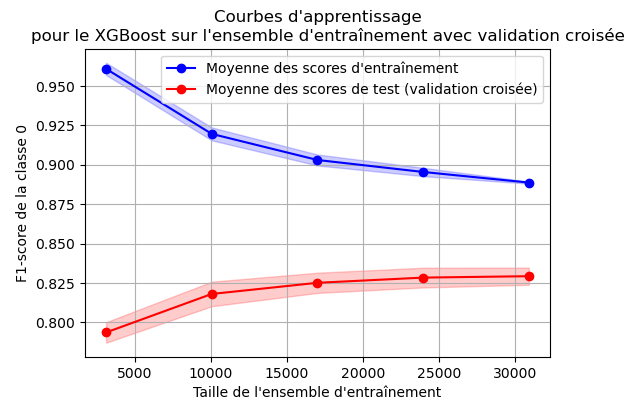

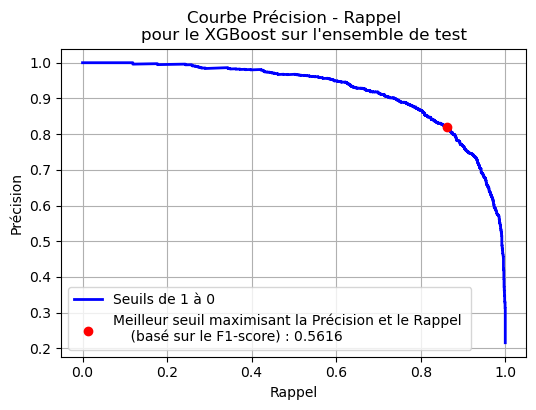

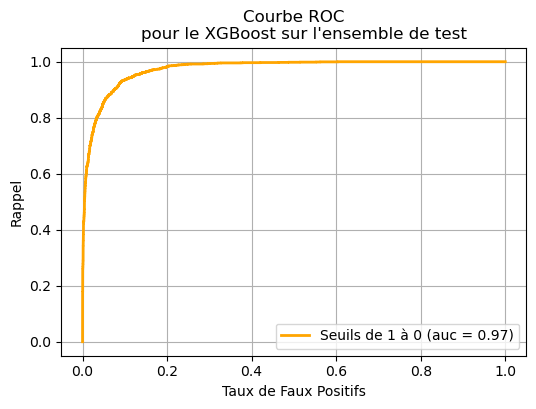

CPU times: user 6.26 s, sys: 1.53 s, total: 7.79 s
Wall time: 24.7 s


In [119]:
%%time

# Courbes d'apprentissage sur l'ensemble d'entraînement avec validation croisée et Log dans MLflow
fig = plot_learning_curves(model_name, pipeline_without_sampling, X_train, y_train, stratified_kfold, f1_score_class_0)
run_id = log_artifact(content=fig, filename=f'learning_curves_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe Précision - Rappel sur l'ensemble de test et Log dans MLflow
fig = plot_precision_recall_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'precision_recall_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

# Courbe ROC sur l'ensemble de test et Log dans MLflow
fig = plot_roc_curve(model_name, trained_grid, X_test, y_test)
run_id = log_artifact(content=fig, filename=f'roc_curve_{run_name}',
                      filetype='png', artifact_path='model_figures', run_id=run_id)

In [171]:
# Chargement du meilleur modèle entraîné (format "Joblib")
best_model = joblib.load('../models/xgboost_best_model.joblib')

# Chargement du meilleur modèle entraîné (format "Pickle")
#best_model = pickle.load(open('../mlflow/mlruns/393622527853827723/9bebb1fb99b14c4695f9488aaa864153/artifacts/model/model.pkl', 'rb'))

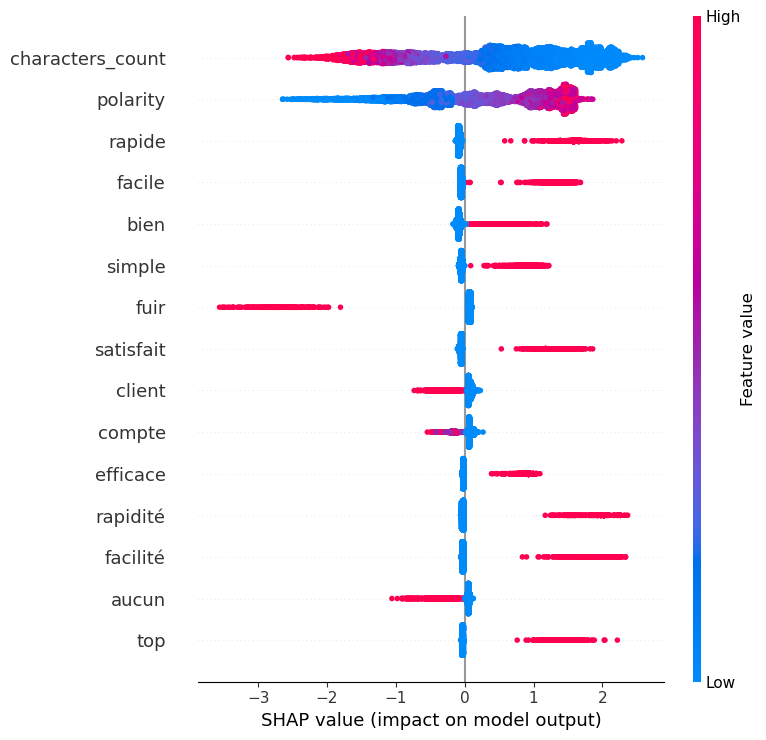

In [172]:
# Création d'un Tree Explainer SHAP pour le modèle XGBoost entraîné
explainer = shap.TreeExplainer(model=best_model.named_steps['model'])

# Récupération des noms des variables explicatives créées après vectorisation et Ajout des autres variables explicatives
vectorizer = best_model.named_steps['preprocessing'].named_transformers_['vectorizer']
vectorizer_features = vectorizer.get_feature_names_out()
all_features = list(vectorizer_features) + ['characters_count', 'polarity']
# >>> ATTENTION ! <<< l'ordre des features est celui des transformations dans ColumnTransformer de ImbPipeline et non pas celui de X_train


# Calcul des valeurs SHAP pour l'ensemble de test identique à celui utilisé pour le test du modèle (matrice essentiellement creuse)
X_test_transformed = best_model.named_steps['preprocessing'].transform(X_test)
shap_values = explainer(X_test_transformed)


# Séparation des 2 types de variables (textuelle et numériques) de X_test puis Vectorisation de la variable textuelle (matrice creuse)
X_text_transformed = vectorizer.transform(X_test['cleaned_review'])
X_num = X_test[['characters_count', 'polarity']]

# Concaténation des variables textuelle et numériques (matrice essentiellement creuse) puis Création d'un DataFrame lisible pour les plots SHAP (matrice dense)
X_test_combined = hstack([X_text_transformed, X_num])
df_X_test_combined = pd.DataFrame(X_test_combined.toarray(), columns=all_features)


# Affichage du summaryplot (interprétation globale de l'impact des variables explicatives sur toutes les prédictions)
shap.summary_plot(shap_values, features=df_X_test_combined, feature_names=all_features, max_display=15)

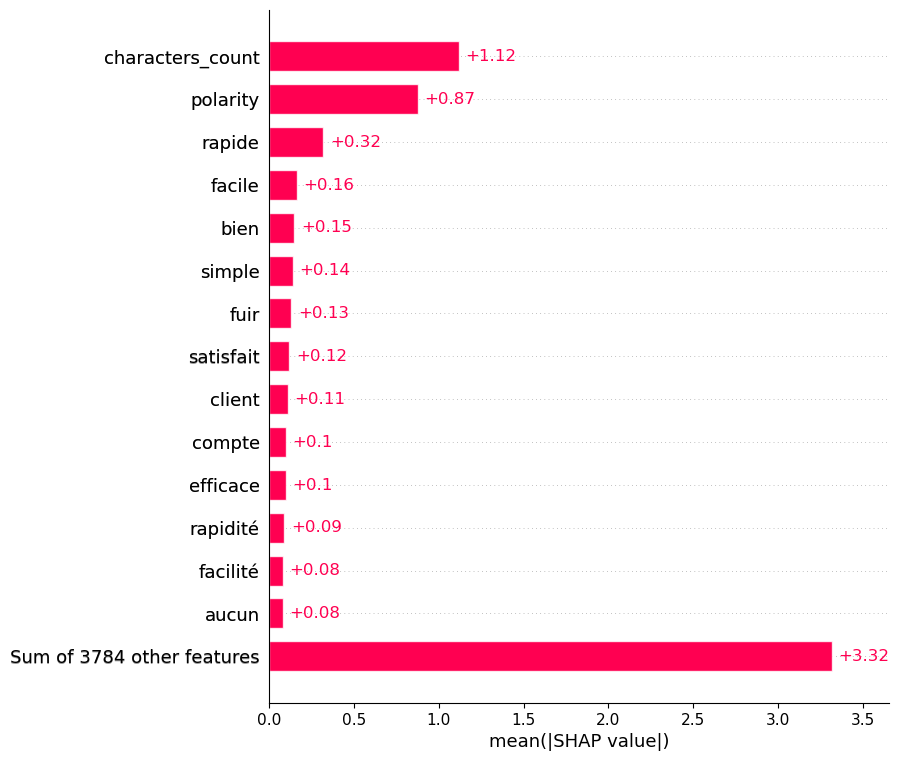

In [173]:
# Création d'un Explanation SHAP avec les noms des variables explicatives
explanation = shap.Explanation(values=shap_values, data=df_X_test_combined, feature_names=all_features)

# Affichage du barplot (importance globale de chaque variable explicative, calculée comme la moyenne absolue des valeurs SHAP sur tout l'ensemble de test)
shap.plots.bar(explanation, max_display=15)

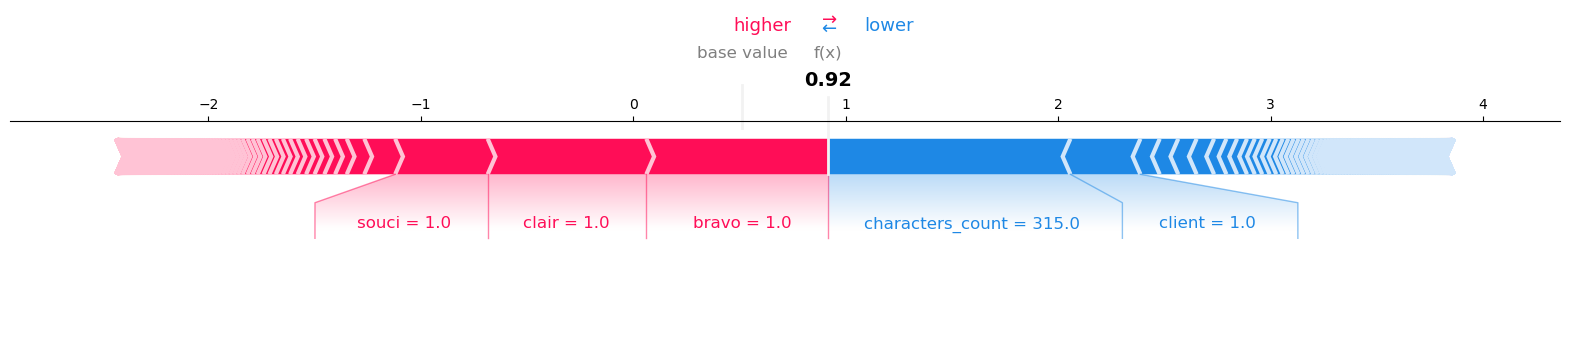

characters_count                                                                                                                                315
polarity                                                                                                                                   0.104286
cleaned_review      fois voir souci service client information clair accessible petit budget rejeter sentir citoyen discriminer faible revenu bravo
Name: 43929, dtype: object

In [174]:
# Affichage du forceplot (interprétation locale de l'impact des variables explicatives sur la prédiction de la 1re observation)
shap.plots.force(shap_values[0], feature_names=all_features, matplotlib=True)

# Affichage de la 1re observation de X_test
X_test.iloc[0,:]